# DATASCI W261: Machine Learning at Scale 

**Team E:  Arthur Mak, Marguerite Oneto, Kasane Utsumi   
atm@ischool.berkeley.edu, marguerite.oneto@ischool.berkeley.edu, kasane@ischool.berkeley.edu   
W261-1 Fall 2015   
Week 13: Homework REDO  
December 16, 2015**  

### For this redo of HW13, we only updatedat 13.1 to use joins with 2 RDDs instead of just 1 RDD with no joins.  Please see below.  Everythin else is the same.

# HW 13.1 REDO: Spark Implementation of Basic PageRank

Rewrite your Spark implementation of the basic PageRank algorithm so that it uses joins.  Optimize its performance by using the available Spark partitioning methods to collect data in both RDDs to the same partition by key.

> ### Results:  100 Iterations Local

> ORIGINAL RUN-TIME WITH NO JOINS AND NO PARTITIONING:
> - real	0m18.847s
- user	0m38.484s
- sys	0m6.585s

> REDO RUN-TIME WITH JOINS AND PARTIONING ON 8 CORES:
> - real	15m3.207s
- user	9m55.999s
- sys	4m2.766s  

> ### Results:  100 Iterations on EMR

> ORIGINAL RUN-TIME WITH NO JOINS AND NO PARTITIONING:
> - real	1m49.235s
- user	0m7.576s
- sys	0m1.072s


> REDO RUN-TIME WITH JOINS AND PARTIONING ON 56 CORES:
> - real	3m37.088s
- user	0m7.588s
- sys	0m0.968s




## 13.1.0 REDO Start Spark

In [2]:
import os
import sys

spark_home = os.environ['SPARK_HOME'] = '/Users/maktrix/Dropbox/Berkeley/W261_ML_scale/spark-1.5.1-bin-hadoop2.6'
# spark_home = os.environ['SPARK_HOME'] = '/usr/local/Cellar/apache-spark/1.5.0/libexec/'
if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.1
      /_/

Using Python version 2.7.10 (default, Oct 19 2015 18:31:17)
SparkContext available as sc, HiveContext available as sqlContext.


## 13.1.1 REDO  Get Data File

In [1]:
!aws s3 cp s3://ucb-mids-mls-networks/PageRank-test.txt PageRank-test.txt

download: s3://ucb-mids-mls-networks/PageRank-test.txt to ./PageRank-test.txt


In [3]:
# check data file
!cat PageRank-test.txt

B	{'C': 1}
C	{'B': 1}
D	{'A': 1, 'B': 1}
E	{'D': 1, 'B': 1, 'F': 1}
F	{'B': 1, 'E': 1}
G	{'B': 1, 'E': 1}
H	{'B': 1, 'E': 1}
I	{'B': 1, 'E': 1}
J	{'E': 1}
K	{'E': 1}


In [4]:
# check to see if data in RDD form looks ok
data_13_1 = (sc
             .textFile('PageRank-test.txt', 4)
             .map(lambda x: (x.split("\t")[0].encode('ascii','ignore'), x.split("\t")[1].encode('ascii','ignore')))
             .cache()
            )
print data_13_1.collect()

[('B', "{'C': 1}"), ('C', "{'B': 1}"), ('D', "{'A': 1, 'B': 1}"), ('E', "{'D': 1, 'B': 1, 'F': 1}"), ('F', "{'B': 1, 'E': 1}"), ('G', "{'B': 1, 'E': 1}"), ('H', "{'B': 1, 'E': 1}"), ('I', "{'B': 1, 'E': 1}"), ('J', "{'E': 1}"), ('K', "{'E': 1}")]


## 13.1.2 REDO   Define PageRank Functions

In [5]:
%%writefile page_rank_REDO.py
#!/usr/bin/env python
import ast
import sys
import time
from pyspark import SparkContext


# Input:  (node, {adjacencies_list})
# Output: [nodes_list]
def get_nodes_REDO(line):
    main_node, adjacencies = line[0], line[1]
    adjacencies = ast.literal_eval(adjacencies)
    nodes = [(main_node, adjacencies)]
    for node in adjacencies.keys():
        nodes.append((node, None))
    return nodes


# Input:  {adjacencies_list} or None
# Output: {adjacencies_list} or None
def final_adjacencies(a, b):
    if a == None:
        if b == None:
            return None
        else:
            return b
    else:
        return a

    
# Input: (node, (adjacency_list, PageRank))
# Output: (node, contribution)
def get_contributions_REDO(main_node, (adjacencies, PageRank)):
    start_time_REDO = time.time()

    if adjacencies == None:
        output = [(main_node, 0)]
        output.append(('dangling_mass', PageRank))
        return output
    else:
        output = [(main_node, 0)]
        adjacencies = ast.literal_eval(str(adjacencies))
        num_adjacencies = len(adjacencies.keys())
        for node in adjacencies.keys(): 
            output.append((node, 1.0*PageRank / num_adjacencies))
        return output
    

# Input: (contributions, d, num_nodes, dangling_mass)
# Output: (new_PageRank)
def calc_pagerank_REDO(contributions, d, num_nodes, dangling_mass):
    PageRank =  1.0*(1.0-d)/num_nodes + \
                1.0*d*(dangling_mass/num_nodes + contributions)  
    return PageRank


def main_page_rank_REDO(input_file,output_file,partitions,d,iterations):

    #get graph from raw data into RDD
    graph = (sc.textFile(input_file, partitions)
             .map(lambda x: (x.split("\t")[0].encode('ascii','ignore'), x.split("\t")[1].encode('ascii','ignore')))
             .cache()
               )
    
    # get all main nodes with their adjacency lists and any adjacent nodes that are dangling nodes
    # Input:  [node, {adjacency_list}]
    # Output: [(node, {adjacency_list} or None)]
    complete_graph = (graph.flatMap(get_nodes_REDO)         
                           .reduceByKey(lambda a, b: final_adjacencies(a,b))        
                           .partitionBy(partitions)
                           .cache()
                     )

    num_nodes = complete_graph.count()  # should force evaluation
    
    # initialize all PageRanks to 1/num_nodes
    # Input: [(node, {adjacency_list} or None)]  
    # Output: [(node, 1/num_nodes)]
    PageRanks = complete_graph.map(lambda (node, adjacencies): (node, 1.0/num_nodes)).cache()    
    PageRanks.take(1)    # should force evaluation
    
    # iteratively calculate new PageRanks
    for i in range(iterations):
        start_time_c = time.time()        

        # join graph and latest page ranks
        joined_graph = (complete_graph
                        .join(PageRanks)
                        .cache()
                        )
        joined_graph.take(1)
        
        # calculate contributions of each node to its adjacencies
        # Input:  [(node, ({adjacencies_list}, PageRank))]
        # Output: [(node, sum of contributions)]

        contributions = (joined_graph
        .flatMap(lambda (node, (adjacencies, PageRank)): get_contributions_REDO(node, (adjacencies, PageRank)))
        .reduceByKey(lambda x, y: x + y)
        .cache()
                        )
        contributions.take(1)
  
        dangling_mass = contributions.lookup('dangling_mass')[0]
        
        # broadcast dangling node mass to all workers
        dangling_mass_br = sc.broadcast(dangling_mass)
        d_br = sc.broadcast(d)
        num_nodes_br = sc.broadcast(num_nodes)
        start_time = time.time()
        # calculate new PageRanks
        # Input:  [(node, sum of contributions)]
        # Output: [(node, PageRank)]
        PageRanks = (contributions
            .filter(lambda (x, y): x != 'dangling_mass')
            .mapValues(lambda contribs: calc_pagerank_REDO(contribs, d_br.value, num_nodes_br.value, dangling_mass_br.value)) 
                     )
        PageRanks.take(1) # forcing evaluation

        # check that PageRanks sum to 1
#         total = PageRanks.aggregate(0, (lambda acc, value: acc + value[1]), (lambda acc1, acc2: acc1 + acc2)) 
#         print >> sys.stdout, "***********************Total PageRank****************************************"
#         print >> sys.stdout, total
        
        print >> sys.stdout, "Iteration: " + str(i) + "  Time: " + str(time.time() - start_time)
        print >> sys.stdout, PageRanks.collect()
    PageRanks.saveAsTextFile(output_file)

if __name__ == "__main__":
    if len(sys.argv) < 5:
        print >> sys.stderr, "Usage: page_rank <initialize sc ?> <input file> <output file> <damping factor> <number_of_iterations>"
        exit(-1)

    input_file = sys.argv[1]
    output_file = sys.argv[2]
    input_partitions = int(sys.argv[3])
    input_d = float(sys.argv[4])
    input_iterations =int(sys.argv[5])
    
    sc = SparkContext(appName="PageRank")
    main_page_rank_REDO(input_file,output_file,input_partitions,input_d,input_iterations)
    sc.stop()    
    



Writing page_rank_REDO.py


## 13.1.3 REDO  Run PageRank Locally

In [ ]:
#ensure folder with output name does not exist
!rm -r 13_1/local_output 

#submit spark job (note that page_rank.py has 5 arguments)
!time /Users/maktrix/Dropbox/Berkeley/W261_ML_scale/spark-1.5.1-bin-hadoop2.6/bin/spark-submit page_rank_REDO.py PageRank-test.txt 13_1/local_output 8 0.85 100    

#output results:
# !rm 13_1/local_output/_SUCCESS
!echo '-----------------OUTPUT-----------------'
!cat 13_1/local_output/part-00000

rm: 13_1/local_output: No such file or directory
15/12/16 15:31:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
15/12/16 15:31:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
15/12/16 15:31:35 WARN MetricsSystem: Using default name DAGScheduler for source because spark.app.id is not set.
Iteration: 0  Time: 0.0631101131439
[('A', 0.05929752066115703), ('C', 0.09793388429752066), ('B', 0.31687327823691464), ('E', 0.32975206611570246), ('D', 0.04641873278236915), ('G', 0.020661157024793392), ('F', 0.04641873278236915), ('I', 0.020661157024793392), ('H', 0.020661157024793392), ('K', 0.020661157024793392), ('J', 0.020661157024793392)]
Iteration: 1  Time: 0.126358032227
[('H', 0.01821844477836214), ('C', 0.2875607312797396), ('K', 0.01821844477836214), ('F', 0.11164819684447784), ('A', 0.037946406210869026), ('I', 0.01821844477836214), ('D', 0.11164819684447784), ('G', 0.01821

## 13.1.3 REDO  Run PageRank on EMR

In [166]:
#copy main PySpark file into EMR master node
!scp -i margueriteoneto2.pem page_rank_REDO.py hadoop@ec2-54-153-4-193.us-west-1.compute.amazonaws.com:.
!scp -i margueriteoneto2.pem page_rank_REDO.py hadoop@ec2-54-153-4-193.us-west-1.compute.amazonaws.com:.

page_rank_REDO.py                             100% 5148     5.0KB/s   00:00    


In [169]:
#ensure folder with output name does not exist
!aws s3 rm --recursive s3://ucb-mids-marguerite-oneto/HW13/13_1_REDO 

#ssh into the cluster and submit spark job with below command:
# >>> ssh -i margueriteoneto2.pem hadoop@ec2-54-153-4-193.us-west-1.compute.amazonaws.com
# >>> time /usr/lib/spark/bin/spark-submit --master yarn-cluster ./page_rank_REDO.py s3://ucb-mids-mls-marguerite-oneto/HW13/PageRank-test.txt s3://ucb-mids-mls-marguerite-oneto/HW13/13_1_REDO 56 0.85 100           
# Elapsed Time:
# real	3m37.088s
# user	0m7.588s
# sys	0m0.968s

# HW 13.1: Spark Implementation of Basic PageRank
>Write a basic Spark implementation of the iterative PageRank algorithm that takes sparse adjacency lists as input.  Make sure that your implementation utilizes teleportation (1-damping/the number of nodes in the network), and further, distributes the mass of dangling nodes with each iteration so that the output of each iteration is correctly normalized (sums to 1).

>[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page, chooses the next page to which it will move by clicking at random, with probability d, one of the hyperlinks in the current page. This probability is represented by a so-called ‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer jumps to any web page in the network. If a page is a dangling end, meaning it has no outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform distribution and “teleports” to that page.]

>In your Spark solution, please use broadcast variables and caching to make sure your code is as efficient as possible.

>As you build your code, use the following test data to check your implementation:

>s3://ucb-mids-mls-networks/PageRank-test.txt

>Set the teleportation parameter to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck your work with the true result, displayed in the first image in the Wikipedia article:

>https://en.wikipedia.org/wiki/PageRank

>and here for reference are the corresponding resulting PageRank probabilities:

>A,0.033    
B,0.384  
C,0.343  
D,0.039  
E,0.081  
F,0.039  
G,0.016  
H,0.016  
I,0.016  
J,0.016  
K,0.016

>Run this experiment locally first. Report the local configuration that you used and how long in minutes and seconds it takes to complete your job.

>Repeat this experiment on AWS. Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete your job. (in your notebook, cat the cluster config file)

>**Known solutions for checking:**  
PAGERANKS AFTER 100 ITERATIONS:  
 
>('A', 0.03278149315934399),  
('B', 0.3844009395952024),  
('C', 0.34291029472673124),   
('D', 0.039087092099966095),   
('E', 0.08088569323449774),   
('F', 0.039087092099966095),  
('G', 0.016169479016858404),   
('H', 0.016169479016858404),   
('I', 0.016169479016858404),   
('J', 0.016169479016858404),   
('K', 0.016169479016858404)


### 13.1.0  Start Spark

In [162]:
import os
import sys

# spark_home = os.environ['SPARK_HOME'] = '/usr/local/Cellar/apache-spark/1.5.0/libexec/'
spark_home = os.environ['SPARK_HOME'] = '/Users/maktrix/Dropbox/Berkeley/W261_ML_scale/spark-1.5.1-bin-hadoop2.6'


if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.1
      /_/

Using Python version 2.7.10 (default, Oct 19 2015 18:31:17)
SparkContext available as sc, HiveContext available as sqlContext.


In [1]:
import os
import sys

spark_home = os.environ['SPARK_HOME'] = '/usr/local/Cellar/apache-spark/1.5.0/libexec/'
if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.0
      /_/

Using Python version 2.7.10 (default, May 28 2015 17:04:42)
SparkContext available as sc, HiveContext available as sqlContext.


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


## 13.1.1  Get Data File

In [ ]:
!aws s3 cp s3://ucb-mids-mls-networks/PageRank-test.txt

In [3]:
#check data file
!cat PageRank-test.txt

B	{'C': 1}
C	{'B': 1}
D	{'A': 1, 'B': 1}
E	{'D': 1, 'B': 1, 'F': 1}
F	{'B': 1, 'E': 1}
G	{'B': 1, 'E': 1}
H	{'B': 1, 'E': 1}
I	{'B': 1, 'E': 1}
J	{'E': 1}
K	{'E': 1}


In [48]:
#check to see if data in RDD form looks ok
data_13_1 = (sc
             .textFile('PageRank-test.txt', 4)
             .map(lambda x: (x.split("\t")[0].encode('ascii','ignore'), x.split("\t")[1].encode('ascii','ignore')))
             .cache()
            )
print data_13_1.collect()

[('B', "{'C': 1}"), ('C', "{'B': 1}"), ('D', "{'A': 1, 'B': 1}"), ('E', "{'D': 1, 'B': 1, 'F': 1}"), ('F', "{'B': 1, 'E': 1}"), ('G', "{'B': 1, 'E': 1}"), ('H', "{'B': 1, 'E': 1}"), ('I', "{'B': 1, 'E': 1}"), ('J', "{'E': 1}"), ('K', "{'E': 1}")]


## 13.1.2  Define PageRank Functions

In [ ]:
%%writefile page_rank.py
#!/usr/bin/env python
import ast
# import time
import sys
from pyspark import SparkContext

# start_time = time.time()

# Input:  (node, {adjacencies_list})
# Output: [nodes_list]
def get_nodes(line):
    main_node, adjacencies = line[0], line[1]
    adjacencies = ast.literal_eval(adjacencies)
    nodes = [main_node]
    for node in adjacencies.keys():
        nodes.append(node)
    return nodes

# Input:  (node, (adjacency_list, PageRank))
# Output: ('dangling_node', (adjacency_list, PageRank or 0))
def get_dangling_node_mass(main_node, (adjacencies, PageRank)):
    if adjacencies == None:
        return [('dangling_node', PageRank)]
    else:
        return [('dangling_node', 0)]

# Input:  (node, (adjacency_list, PageRank))
# Output: (node, (adjacency_list, PageRank))
def get_contributions(main_node, (adjacencies, PageRank)):
    if adjacencies == None:
        return [(main_node, (adjacencies, 0))]
    else:
        output = [(main_node, (adjacencies, 0))]
        adjacencies = ast.literal_eval(adjacencies)
        num_adjacencies = len(adjacencies.keys())
        for node in adjacencies.keys():
            output.append((node, (None, 1.0*PageRank / num_adjacencies)))
        return output

# Input:  (adjacency_list, PageRank)
# Output: (adjacency_list, PageRank)
def sum_contributions(a, b):
    if a[0] == None:
        if b[0] == None:
            return (None, a[1] + b[1])
        else:
            return (b[0], a[1] + b[1])
    else:
        return (a[0], a[1] + b[1])

    
# Input:  (adjacency_list, PageRank)
# Output: (adjacency_list, new_PageRank)
def calc_pagerank(adjacencies, PageRank, d, num_nodes, dangling_mass):
#     PageRank =  1.0*(1.0-d_br.value)/num_nodes_br.value + \
#                 1.0*d_br.value*(dangling_mass_br.value/num_nodes_br.value + PageRank)  

    PageRank =  1.0*(1.0-d)/num_nodes + \
                1.0*d*(dangling_mass/num_nodes + PageRank)  

    return (adjacencies, PageRank)


def main_page_rank(input_file,output_file,d,iterations):

    #get node and neighbor info from raw data into RDD
    data = (sc.textFile(input_file, 4)
             .map(lambda x: (x.split("\t")[0].encode('ascii','ignore'), x.split("\t")[1].encode('ascii','ignore')))
             .cache()
               )

    # get all main nodes with their adjacency lists and any adjacent nodes that are dangling nodes
    # Input:  [node, {adjacency_list}]
    # Output: [(node, {adjacency_list} or None)]
    unique_nodes = (data.map(lambda x: x).flatMap(get_nodes)         
                     .distinct()                     
                     .map(lambda x: (x, ''))         
                     .leftOuterJoin(data)       
                     .map(lambda (x, y): (x, y[1]))  
#                          .partitionBy(8)
#                          .persist()
                     .cache()
                   )

    num_nodes = unique_nodes.count()
#     num_nodes_br = sc.broadcast(num_nodes)

    # initialize all PageRanks to 1/num_nodes
    # Input: [(node, {adjacency_list} or None)]  
    # Output: [(node, ({adjacency_list}, 1/num_nodes))]
#     PageRanks = unique_nodes.flatMap(lambda (node, adjacencies): [(node, (adjacencies, 1.0/num_nodes_br.value))]).cache()
    PageRanks = unique_nodes.flatMap(lambda (node, adjacencies): [(node, (adjacencies, 1.0/num_nodes))]).cache()


    # iteratively calculate new PageRanks
#     iterations = 3
#     d = 0.85


    for i in range(iterations):
        # calculate dangling node mass
        # Input:  [(node, ({adjacencies_list}, PageRank))]
        # Output: [('dangling_node', (None, PageRank))]
        dangling_mass = (PageRanks
            .flatMap(lambda (node, (adjacencies, PageRank)): get_dangling_node_mass(node, (adjacencies, PageRank)))
            .aggregate(0, (lambda acc, value: acc + value[1]), (lambda acc1, acc2: acc1 + acc2))
                         )

        # calculate contributions of each node to its adjacencies
        # Input:  [(node, ({adjacencies_list}, PageRank))]
        # Output: [(node, ({adjacencies_list}, PageRank))]
        PageRanks = (PageRanks
            .flatMap(lambda (node, (adjacencies, PageRank)): get_contributions(node, (adjacencies, PageRank)))
            .reduceByKey(lambda a, b: sum_contributions(a, b))
            .cache()
                     )

        PageRanks.count() # this random action is needed to get the dangling node mass accumulator to run

        # broadcast parameters and dangling node mass to all workers
#         d_br = sc.broadcast(d)
#         num_nodes_br = sc.broadcast(num_nodes)
        dangling_mass_br = sc.broadcast(dangling_mass)

        # calculate new PageRanks
        # Input:  [(node, ({adjacencies_list}, PageRank))]
        # Output: [(node, ({adjacencies_list}, PageRank))]
#         PageRanks = (PageRanks.mapValues(lambda (adjacencies, PageRank): calc_pagerank(adjacencies, PageRank))     
#                      )

        PageRanks = (PageRanks.mapValues(lambda (adjacencies, PageRank): calc_pagerank(adjacencies, PageRank, d, num_nodes, dangling_mass_br.value)) 
                     )
        
#         # check that PageRanks sum to 1
#         total = PageRanks.aggregate(0, (lambda acc, value: acc + value[1][1]), (lambda acc1, acc2: acc1 + acc2))
#         print 'Sum of all new PageRanks for iteration %i = %f' %(i + 1, total)

#     elapsed_time = time.time() - start_time
#     print 'Total run-time was %f seconds.' %(elapsed_time)
    print 'Final PageRanks after %i iterations:' %(iterations)
#     print PageRanks.collect()

    PageRanks.saveAsTextFile(output_file)

if __name__ == "__main__":
    if len(sys.argv) < 4:
        print >> sys.stderr, "Usage: page_rank <initialize sc ?> <input file> <output file> <damping factor> <number_of_iterations>"
        exit(-1)

    input_file = sys.argv[1]
    output_file = sys.argv[2]
    input_d = float(sys.argv[3])
    input_iterations =int(sys.argv[4])
    
    sc = SparkContext(appName="PageRank")
    main_page_rank(input_file,output_file,input_d, input_iterations)
    sc.stop()

## 13.1.3 Run PageRank in Spark locally

In [ ]:
#ensure folder wit output name does not exist
!rm -r 13_1/local_output 

#submit spark job (note that page_rank.py has 4 arguments)
!time /Users/maktrix/Dropbox/Berkeley/W261_ML_scale/spark-1.5.1-bin-hadoop2.6/bin/spark-submit page_rank.py PageRank-test.txt 13_1/local_output 0.85 100    
# !time /usr/local/Cellar/apache-spark/1.5.0/libexec/bin/spark-submit page_rank.py PageRank-test.txt 13_1/local_output 0.85 100    

#output results:
!rm 13_1/local_output/_SUCCESS
!echo '-----------------OUTPUT-----------------'
!cat 13_1/local_output/*

## 13.1.4 Run PageRank in Spark on EMR cluster

In [26]:
#create cluster
!aws emr create-cluster --name "13_1" --ami-version 3.8 --applications Name=Spark --ec2-attributes KeyName=w261_key2 --log-uri s3://ucb-mids-mls-arthur-mak/test_spark/logs --instance-type m3.xlarge  --instance-count 3 --use-default-roles 

j-3FXC4UUAJL8CN


In [90]:
#copy main PySpark file into EMR master node
!scp -i /Users/maktrix/Dropbox/Berkeley/W261_ML_scale/w261_key2.pem page_rank.py hadoop@ec2-52-26-34-50.us-west-2.compute.amazonaws.com:code/.

page_rank.py                                  100% 6033     5.9KB/s   00:00    


In [91]:
#ensure folder with output name does not exist
!aws s3 rm --recursive s3://ucb-mids-mls-group-e/hw13/13_1_1 

#ssh into the cluster and submit spark job with below command:
# >>> ssh -i w261_key2.pem hadoop@ec2-52-26-34-50.us-west-2.compute.amazonaws.com
# >>> time /home/hadoop/spark/bin/spark-submit --master yarn-cluster ./code/page_rank.py s3n://ucb-mids-mls-networks/PageRank-test.txt s3n://ucb-mids-mls-group-e/hw13/13_1_1 0.85 100

delete: s3://ucb-mids-mls-group-e/hw13/13_1_1/_SUCCESS
delete: s3://ucb-mids-mls-group-e/hw13/13_1_1/part-00002
delete: s3://ucb-mids-mls-group-e/hw13/13_1_1/part-00000
delete: s3://ucb-mids-mls-group-e/hw13/13_1_1/part-00003
delete: s3://ucb-mids-mls-group-e/hw13/13_1_1/part-00004
delete: s3://ucb-mids-mls-group-e/hw13/13_1_1/part-00007
delete: s3://ucb-mids-mls-group-e/hw13/13_1_1/part-00001
delete: s3://ucb-mids-mls-group-e/hw13/13_1_1/part-00005
delete: s3://ucb-mids-mls-group-e/hw13/13_1_1/part-00006


In [93]:
#This is the time record displayed on the EMR terminal
# real	1m49.235s
# user	0m7.576s
# sys	0m1.072s

In [96]:
#remove output folder of same name
!rm -r 13_1_1/emr_output

#download the result from S3
!aws s3 rm s3://ucb-mids-mls-group-e/hw13/13_1_1/_SUCCESS
!aws s3 cp --recursive s3://ucb-mids-mls-group-e/hw13/13_1_1 13_1_1/emr_output
!echo '-----------------OUTPUT-----------------'
!cat 13_1_1/emr_output/*


download: s3://ucb-mids-mls-group-e/hw13/13_1_1/part-00002 to 13_1_1/emr_output/part-00002
download: s3://ucb-mids-mls-group-e/hw13/13_1_1/part-00000 to 13_1_1/emr_output/part-00000
download: s3://ucb-mids-mls-group-e/hw13/13_1_1/part-00004 to 13_1_1/emr_output/part-00004
download: s3://ucb-mids-mls-group-e/hw13/13_1_1/part-00007 to 13_1_1/emr_output/part-00007
download: s3://ucb-mids-mls-group-e/hw13/13_1_1/part-00001 to 13_1_1/emr_output/part-00001
download: s3://ucb-mids-mls-group-e/hw13/13_1_1/part-00003 to 13_1_1/emr_output/part-00003
download: s3://ucb-mids-mls-group-e/hw13/13_1_1/part-00005 to 13_1_1/emr_output/part-00005
download: s3://ucb-mids-mls-group-e/hw13/13_1_1/part-00006 to 13_1_1/emr_output/part-00006
-----------------OUTPUT-----------------
('A', (None, 0.032781493159343991))
('I', ("{'B': 1, 'E': 1}", 0.016169479016858404))
('H', ("{'B': 1, 'E': 1}", 0.016169479016858404))
('C', ("{'B': 1}", 0.34291029472673129))
('K', ("{'E': 1}", 0.016169479016858404))
('J', ("{'E'

## 13.1.5 Compare execution time
The local configuration is as follow:
- MacBook Air (13-inch, Mid 2013)
- Processor 1.4 GHz Intel Core i5
- Memory 8 GB 1600 MHz DDR3
- Graphics Intel HD Graphics 5000 1536 MB
- OSX version 10.10.2

The EMR cluster configuration is as follow:
- instance-type m3.xlarge  
- instance-count 3
- region us-west-2

We used the elapsed real time between command line invocation and termination as our time benchmark for execution time:
- Total execution time for local computer is: 1m6.773s
- Total execution time for EMR cluster is: 1m49.235s

The real execution time for EMR cluster is actually longer even though computational time is likely to be less for the EMR cluster. 

# HW 13.2: Applying PageRank to the Wikipedia hyperlinks network===
>Run your Spark PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

>Run your PageRank implementation on the Wikipedia dataset for 50 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 
Plot the pagerank values for the top 100 pages resulting from the 50 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  Comment on your findings.  Have the top 100 ranked pages changed? Have the pagerank values changed? Explain.

>Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete your job.

>NOTE: Wikipedia data is located on S3 at  s3://ucb-mids-mls-networks/wikipedia/
-- s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt # Graph
-- s3://ucb-mids-mls-networks/wikipedia/indices.txt               # Page titles and page Ids

## 13.2.1 Config Spark PageRank Function
We only need the "all-pages-indexed-out.txt" file because that file contains the list of all nodes and it's out-going neigbours. That is all we need to run the page rank algorithm. 

The page rank algorithm needs to be slightly altered to accomodate for getting the top 100 ranked nodes.  

In [47]:
%%writefile page_rank2.py
#!/usr/bin/env python
import ast
import sys
from pyspark import SparkContext
                                                               
# Input:  (node, {adjacencies_list})
# Output: [nodes_list]
def get_nodes(line):
    main_node, adjacencies = line[0], line[1]
    adjacencies = ast.literal_eval(adjacencies)
    nodes = [main_node]
    for node in adjacencies.keys():
        nodes.append(node)
    return nodes

# Input:  (node, (adjacency_list, PageRank))
# Output: ('dangling_node', (adjacency_list, PageRank or 0))
def get_dangling_node_mass(main_node, (adjacencies, PageRank)):
    if adjacencies == None:
        return [('dangling_node', PageRank)]
    else:
        return [('dangling_node', 0)]

# Input:  (node, (adjacency_list, PageRank))
# Output: (node, (adjacency_list, PageRank))
def get_contributions(main_node, (adjacencies, PageRank)):
    if adjacencies == None:
        return [(main_node, (adjacencies, 0))]
    else:
        output = [(main_node, (adjacencies, 0))]
        adjacencies = ast.literal_eval(adjacencies)
        num_adjacencies = len(adjacencies.keys())
        for node in adjacencies.keys():
            output.append((node, (None, 1.0*PageRank / num_adjacencies)))
        return output

# Input:  (adjacency_list, PageRank)
# Output: (adjacency_list, PageRank)
def sum_contributions(a, b):
    if a[0] == None:
        if b[0] == None:
            return (None, a[1] + b[1])
        else:
            return (b[0], a[1] + b[1])
    else:
        return (a[0], a[1] + b[1])

    
# Input:  (adjacency_list, PageRank)
# Output: (adjacency_list, new_PageRank)
def calc_pagerank(adjacencies, PageRank, d, num_nodes, dangling_mass):
    PageRank =  1.0*(1.0-d)/num_nodes + \
                1.0*d*(dangling_mass/num_nodes + PageRank)  

    return (adjacencies, PageRank)


def main_page_rank(input_file,output_file,d,iterations,num_ranks):
    #get node and neighbor info from raw data into RDD
    data = (sc.textFile(input_file, 4)
             .map(lambda x: (x.split("\t")[0].encode('ascii','ignore'), x.split("\t")[1].encode('ascii','ignore')))
             .cache()
               )
    
    # get all main nodes with their adjacency lists and any adjacent nodes that are dangling nodes
    # Input:  [node, {adjacency_list}]
    # Output: [(node, {adjacency_list} or None)]
    unique_nodes = (data.map(lambda x: x).flatMap(get_nodes)         
                     .distinct()                     
                     .map(lambda x: (x, ''))         
                     .leftOuterJoin(data)       
                     .map(lambda (x, y): (x, y[1]))  
                     .cache()
                   )
    num_nodes = unique_nodes.count()

    # initialize all PageRanks to 1/num_nodes
    # Input: [(node, {adjacency_list} or None)]  
    # Output: [(node, ({adjacency_list}, 1/num_nodes))]
    PageRanks = unique_nodes.flatMap(lambda (node, adjacencies): [(node, (adjacencies, 1.0/num_nodes))]).cache()

    # iteratively calculate new PageRanks
    for i in range(iterations):
        # calculate dangling node mass
        # Input:  [(node, ({adjacencies_list}, PageRank))]
        # Output: [('dangling_node', (None, PageRank))]
        dangling_mass = (PageRanks
            .flatMap(lambda (node, (adjacencies, PageRank)): get_dangling_node_mass(node, (adjacencies, PageRank)))
            .aggregate(0, (lambda acc, value: acc + value[1]), (lambda acc1, acc2: acc1 + acc2))
                         )

        # calculate contributions of each node to its adjacencies
        # Input:  [(node, ({adjacencies_list}, PageRank))]
        # Output: [(node, ({adjacencies_list}, PageRank))]
        PageRanks = (PageRanks
            .flatMap(lambda (node, (adjacencies, PageRank)): get_contributions(node, (adjacencies, PageRank)))
            .reduceByKey(lambda a, b: sum_contributions(a, b))
            .cache()
                     )

        PageRanks.count() # this random action is needed to get the dangling node mass accumulator to run

        # broadcast parameters and dangling node mass to all workers
        dangling_mass_br = sc.broadcast(dangling_mass)

        # calculate new PageRanks
        # Input:  [(node, ({adjacencies_list}, PageRank))]
        # Output: [(node, ({adjacencies_list}, PageRank))]
        PageRanks = (PageRanks.mapValues(lambda (adjacencies, PageRank): calc_pagerank(adjacencies, PageRank, d, num_nodes, dangling_mass_br.value)) 
                     )
        
#         # check that PageRanks sum to 1
#         total = PageRanks.aggregate(0, (lambda acc, value: acc + value[1][1]), (lambda acc1, acc2: acc1 + acc2))
#         print 'Sum of all new PageRanks for iteration %i = %f' %(i + 1, total)

#     elapsed_time = time.time() - start_time
#     print 'Total run-time was %f seconds.' %(elapsed_time)
    print 'Final PageRanks after %i iterations:' %(iterations)   
#     PageRanks.saveAsTextFile(output_file)

    #rank by top page rank score
    top_ranks = PageRanks.takeOrdered(num_ranks, lambda (k, v): -v[1])
    sc.parallelize(top_ranks).coalesce(1).saveAsTextFile(output_file)
        
if __name__ == "__main__":
    if len(sys.argv) < 4:
        print >> sys.stderr, "Usage: page_rank <initialize sc ?> <input file> <output file> <damping factor> <number_of_iterations>"
        exit(-1)

    input_file = sys.argv[1]
    output_file = sys.argv[2]
    input_d = float(sys.argv[3])
    input_iterations =int(sys.argv[4])
    input_num_ranks =int(sys.argv[5])
    
    sc = SparkContext(appName="PageRank")
    main_page_rank(input_file,output_file,input_d,input_iterations,input_num_ranks)
    sc.stop()

Overwriting page_rank2.py


## 13.2.2 Run PageRank Algorithm on Wikipedia Dataset (10 Iterations)

Create a json conf that maximize the resource allocation:
- source:   http://docs.aws.amazon.com/ElasticMapReduce/latest/ReleaseGuide/emr-spark-configure.html

In [63]:
%%writefile emr_config_spark_max.json
[
  {
    "Classification": "spark",
    "Properties": {
      "maximizeResourceAllocation": "true"
    }
  }
]

Overwriting emr_config_spark_max.json


In [71]:
#create cluster with updated version
!aws emr create-cluster --name "13_2" --release-label emr-4.2.0 --applications Name=Spark --instance-count 10 --use-default-roles --ec2-attributes KeyName=w261_key2 --instance-type m3.xlarge  --enable-debugging --log-uri s3://ucb-mids-mls-group-e/hw13 --configurations file://./emr_config_spark_max.json

j-SQLW1RWA7SQ9


In [74]:
#copy main PySpark file into EMR master node
!scp -i /Users/maktrix/Dropbox/Berkeley/W261_ML_scale/w261_key2.pem page_rank2.py hadoop@ec2-52-35-14-137.us-west-2.compute.amazonaws.com:code/.

page_rank2.py                                 100% 5933     5.8KB/s   00:00    


In [76]:
#make sure output folder of same name does not exist
!aws s3 rm --recursive s3://ucb-mids-mls-group-e/hw13/13_2

#ssh into the cluster and submit spark job with below command:
# >>> ssh -i w261_key2.pem hadoop@ec2-52-35-14-137.us-west-2.compute.amazonaws.com
# >>> time /usr/lib/spark/bin/spark-submit --master yarn-cluster ./code/page_rank2.py s3n://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt s3n://ucb-mids-mls-group-e/hw13/13_2_10runs 0.85 10 100

delete: s3://ucb-mids-mls-group-e/hw13/13_2/part-00000


This is the system time reported for running 10 iterations on wikipedia dataset:  
real	50m20.958s  
user	0m11.040s  
sys	0m1.328s  

In [20]:
#remove output folder of same name
!rm -r 13_2/emr_output_10

#download the result from S3
!aws s3 cp s3://ucb-mids-mls-group-e/hw13/13_2_10runs/part-00000 13_2/emr_output_10/part_00000
!echo '-----------------OUTPUT is in the form of (node,{adjacencies},score)-----------------'
!cat 13_2/emr_output_10/part_00000

download: s3://ucb-mids-mls-group-e/hw13/13_2_10runs/part-00000 to 13_2/emr_output_10/part_00000
-----------------OUTPUT is in the form of (node,{adjacencies},score)-----------------
('13455888', ("{'2437837': 1, '4652969': 1, '11699135': 2, '2760393': 1, '10017086': 1, '5551197': 1, '14873467': 1, '3122567': 1, '7156598': 1, '12395575': 3, '13470333': 1, '10917268': 1, '12257533': 1, '15191118': 1, '5262932': 1, '15132253': 1, '5045896': 1, '8047447': 2, '15093562': 1, '4164784': 1, '4841768': 2, '7834768': 1, '15093051': 1, '14872084': 1, '9656908': 1, '9553268': 1, '8695810': 1, '5263286': 1, '3578632': 1, '14694142': 1, '13443136': 1, '13430706': 1, '10284369': 1, '2914403': 1, '13433429': 1, '9996695': 1, '10895162': 1, '1477521': 1, '13143901': 1, '8502227': 1, '14856101': 1, '7487918': 1, '15019001': 1, '14694254': 1, '3124289': 1, '2547471': 1, '862916': 2, '14592026': 1, '14956484': 1, '13169042': 1, '12082829': 2, '1804244': 1, '4504662': 1, '8982971': 1, '6067892': 2, '78014

## 13.2.2 Run PageRank Algorithm on Wikipedia Dataset (50 Iterations)
We reused the same cluster. Just need to change the 2nd-to-last argument of the "spark-submit" command line from 10 to 50. 

In [ ]:
#make sure output folder of same name does not exist
!aws s3 rm --recursive s3://ucb-mids-mls-group-e/hw13/13_2_50runs

#ssh into the cluster and submit spark job with below command (spark-submit command line has changed no. of iterations from 10 to 50):
# >>> ssh -i w261_key2.pem hadoop@ec2-52-35-14-137.us-west-2.compute.amazonaws.com
# >>> time /usr/lib/spark/bin/spark-submit --master yarn-cluster ./code/page_rank2.py s3n://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt s3n://ucb-mids-mls-group-e/hw13/13_2_50runs 0.85 50 100

This is the system time reported for running 50 iterations on wikipedia dataset:  
real	251m3.142s  
user	0m22.568s  
sys	0m3.428s

In [18]:
#remove local output folder of same name
!rm -r 13_2/emr_output_50

#download the result from S3
!mkdir 13_2/emr_output_50
!aws s3 cp s3://ucb-mids-mls-group-e/hw13/13_2_50runs/part-00000 13_2/emr_output_50/part_00000
!echo '-----------------OUTPUT is in the form of (node,{adjacencies},score)-----------------'
!cat 13_2/emr_output_50/part_00000

download: s3://ucb-mids-mls-group-e/hw13/13_2_50runs/part-00000 to 13_2/emr_output_50/part_00000
-----------------OUTPUT is in the form of (node,{adjacencies},score)-----------------
('13455888', ("{'2437837': 1, '4652969': 1, '11699135': 2, '2760393': 1, '10017086': 1, '5551197': 1, '14873467': 1, '3122567': 1, '7156598': 1, '12395575': 3, '13470333': 1, '10917268': 1, '12257533': 1, '15191118': 1, '5262932': 1, '15132253': 1, '5045896': 1, '8047447': 2, '15093562': 1, '4164784': 1, '4841768': 2, '7834768': 1, '15093051': 1, '14872084': 1, '9656908': 1, '9553268': 1, '8695810': 1, '5263286': 1, '3578632': 1, '14694142': 1, '13443136': 1, '13430706': 1, '10284369': 1, '2914403': 1, '13433429': 1, '9996695': 1, '10895162': 1, '1477521': 1, '13143901': 1, '8502227': 1, '14856101': 1, '7487918': 1, '15019001': 1, '14694254': 1, '3124289': 1, '2547471': 1, '862916': 2, '14592026': 1, '14956484': 1, '13169042': 1, '12082829': 2, '1804244': 1, '4504662': 1, '8982971': 1, '6067892': 2, '78014

## 13.2.3 Top Nodes
Now, we already have the node indices results for top 100 page rank nodes (for both 10 iterations and 50 iterations respectively). We need to convert these node indices into the actual node name. Thus, we need to perform join operation with the data from: s3://ucb-mids-mls-networks/wikipedia/indices.txt

As a reminder, the "indices.txt" data is in the following form:  
- (article name) \t (index) \t (in degree) \t (out degree)

### Create new function to join and create (node_name,score)

In [87]:
%%writefile NodenameScore.py
import sys
import json
import ast
import re
from pyspark import SparkContext

def nodename_score(pagerank_file, indices_file, output_file):
    #rdd of (node_id, node_name)
    indices = (sc.textFile(indices_file)
                .map(lambda line: (
                    line.split("\t")[1].encode('ascii','ignore'),
                    line.split("\t")[0].encode('ascii','ignore')))
              )
    #rdd of (node_id, score)
    scores = (sc.textFile(pagerank_file)
                        .map(lambda line: (
                             ast.literal_eval(line)[0],
                             ast.literal_eval(line)[1][1]))
                   )
    #join with final output of (node_name, score)
    names_scores = scores.leftOuterJoin(indices).map(lambda (x,y): (y[1],y[0])).takeOrdered(100,lambda (k,v): -v)
    sc.parallelize(names_scores).coalesce(1).saveAsTextFile(output_file)

if __name__ == "__main__":
    if len(sys.argv) < 3:
        print >> sys.stderr, "Usage: nodename_score <pagerank_file> <indices_file> <output_file>"
        exit(-1)

    [pagerank_file, indices_file, output_file] = sys.argv[1:4]
    
    
    sc = SparkContext(appName="Nodename_Score")
    nodename_score(pagerank_fileand , indices_file, output_file)    
    sc.stop()



Overwriting NodenameScore.py


### Configure new cluster

In [10]:
#copy the main PySpark file to the cluster
!scp -i /Users/maktrix/Dropbox/Berkeley/W261_ML_scale/w261_key2.pem NodenameScore.py hadoop@ec2-52-35-14-137.us-west-2.compute.amazonaws.com:code/.

NodenameScore.py                              100% 1257     1.2KB/s   00:00    


### Submit Spark job to create (node_name, score) for 10-iteration case and 50-iteration case

In [ ]:
##ssh into the cluster and submit spark job with below commands (spark-submit command line has changed no. of iterations from 10 to 50):
# >>> ssh -i w261_key2.pem hadoop@ec2-52-11-63-26.us-west-2.compute.amazonaws.com
# >>> time /usr/lib/spark/bin/spark-submit --master yarn-cluster ./code/NodenameScore.py s3n://ucb-mids-mls-group-e/hw13/13_2_10runs/part-00000 s3n://ucb-mids-mls-networks/wikipedia/indices.txt s3n://ucb-mids-mls-group-e/hw13/13_2/nodescore_10runs
# >>> time /usr/lib/spark/bin/spark-submit --master yarn-cluster ./code/NodenameScore.py s3n://ucb-mids-mls-group-e/hw13/13_2_50runs/part-00000 s3n://ucb-mids-mls-networks/wikipedia/indices.txt s3n://ucb-mids-mls-group-e/hw13/13_2/nodescore_50runs

In [15]:
#Copy output files for both 10-iteration and 50-iteration cases from AWS
!aws s3 cp s3://ucb-mids-mls-group-e/hw13/13_2/nodescore_10runs/part-00000 13_2/nodescore_10runs.txt
# !aws s3 cp s3://ucb-mids-mls-group-e/hw13/13_2/nodescore_50runs/part-00000 13_2/nodescore_50runs.txt

download: s3://ucb-mids-mls-group-e/hw13/13_2/nodescore_10runs/part-00000 to 13_2/nodescore_10runs.txt
download: s3://ucb-mids-mls-group-e/hw13/13_2/nodescore_50runs/part-00000 to 13_2/nodescore_50runs.txt


### Create table for displaying the results
We will create a table that list the top 100 ranked nodes for the 10-iteration and 50-iteration cases (1 being top rank).

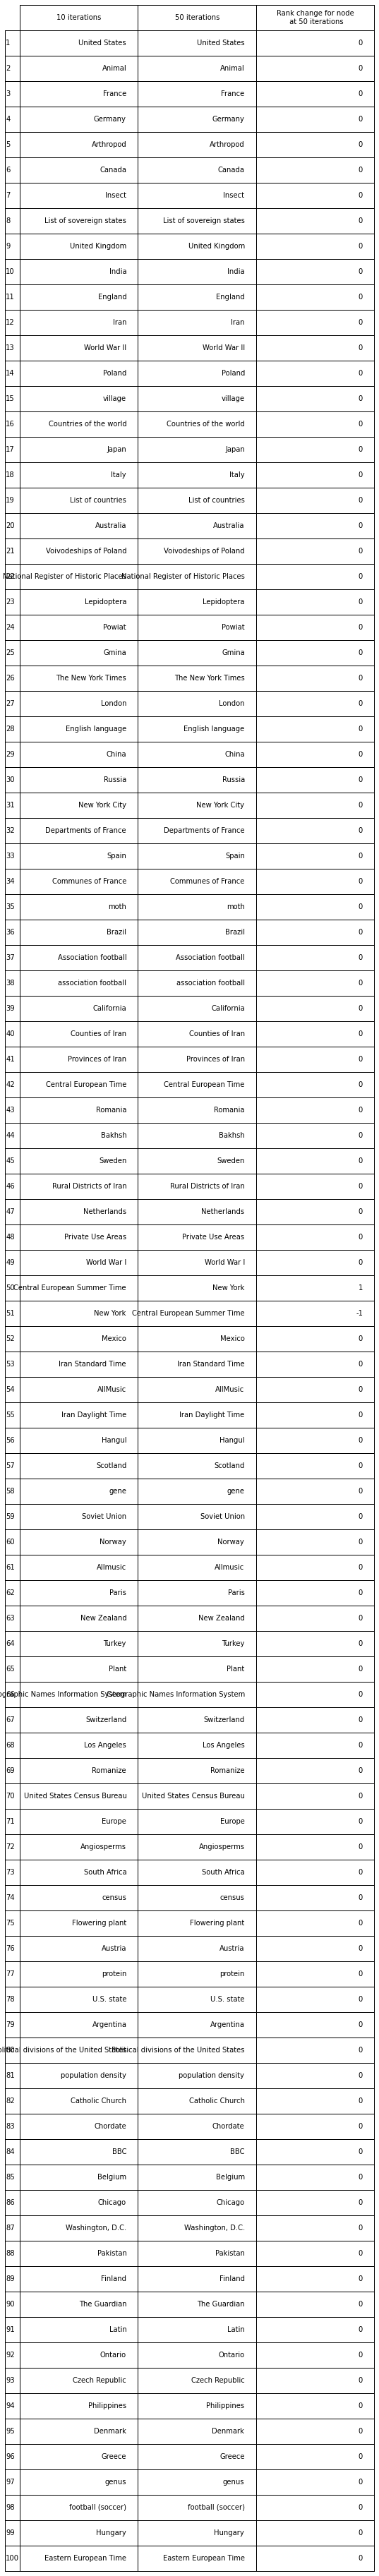

In [25]:
#plot the findings
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ast

colLabels = ["10 iterations","50 iterations", "Rank change for node\n at 50 iterations"]
rowLabels=list(range(1, 101, 1))

#fill in ranking from both iterations
myData = np.empty((100,3), dtype=object)

#variables for storing the node name for 10 and 50 iteration modes
nodenames_10 = []
nodenames_50 = []

#add the node names of top 100 ranked nodes for 10-iteration case to data
with open('13_2/nodescore_10runs.txt','r') as nodescores_10runs:
    for i, nodescore_10 in enumerate(nodescores_10runs):
        (nodename_10,score_10) = ast.literal_eval(nodescore_10)
        myData[i][0] = nodename_10
        nodenames_10.append(nodename_10)

#add the node names of the top 100 ranked nodes for 50-iteration case to data        
with open('13_2/nodescore_50runs.txt','r') as nodescores_50runs:
    for i, nodescore_50 in enumerate(nodescores_50runs):
        (nodename_50,score_50) = ast.literal_eval(nodescore_50)
        myData[i][1] = nodename_50
        nodenames_50.append(nodename_50)

for i, nodename_50 in enumerate(nodenames_50):
    if nodename_50 not in nodenames_10:
        myData[i][2] = 100-i
    else:
        index_10 = nodenames_10.index(nodename_50)
        myData[i][2] = index_10-i
        

ax = plt.subplot(111,frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
myTable = plt.table(cellText=myData, rowLabels = rowLabels, colLabels=colLabels, loc='center')

#myTable.scale(3,3)
myTable.auto_set_font_size(False)
myTable.set_fontsize(10)
myTable.scale(3, 3)  # may help
myTable.properties()

#set width
prop = myTable.properties()
cells = prop['child_artists']
for cell in cells:
    cell.set_width(0.5)

plt.show()

The result shows that from 10 iterations to 50 iterations, the top 100 ranked results didn't change at all

## 13.2.4 Page Rank Values
We plotted the rank score for both 10-iteration and 50-iteration cases for their top 100 results. We used the log of the rank score value to provide better resolution. 

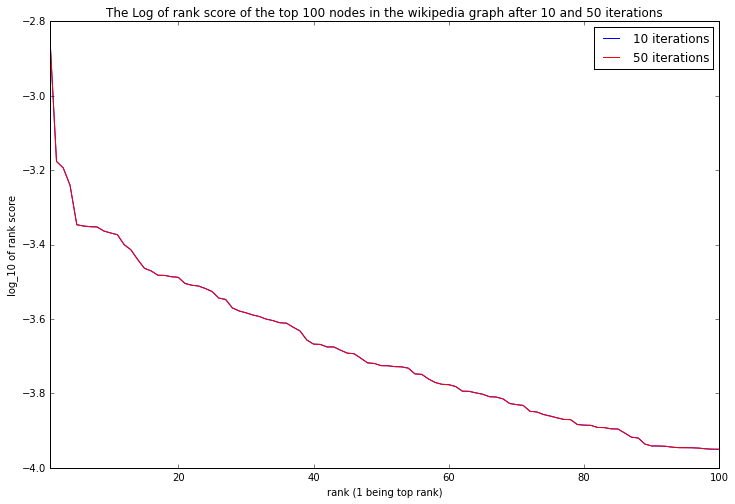

In [24]:
#plot it
%matplotlib inline
import math

#store the log of the rank scores for 10 and 50 iteration cases
log_score_10=[]
log_score_50=[]

#add the log(score) of top 100 ranked nodes for 10-iteration case to data
with open('13_2/nodescore_10runs.txt','r') as nodescores_10runs:
    for i, nodescore_10 in enumerate(nodescores_10runs):
        (nodename_10,score_10) = ast.literal_eval(nodescore_10)
        log_score_10.append(math.log10(float(score_10)))

#add the log(score) of the top 100 ranked nodes for 50-iteration case to data        
with open('13_2/nodescore_50runs.txt','r') as nodescores_50runs:
    for i, nodescore_50 in enumerate(nodescores_50runs):
        (nodename_50,score_50) = ast.literal_eval(nodescore_50)
        log_score_50.append(math.log10(float(score_50)))

#plot graph
ranks = list(range(1, 101, 1)) 
plt.figure(figsize=(12, 8))
plt.title('The Log of rank score of the top 100 nodes in the wikipedia graph after 10 and 50 iterations')
plt.ylabel('log_10 of rank score')
plt.xlabel('rank (1 being top rank)')
plt.xlim(1,100)
#legend tutorial: http://matplotlib.org/users/legend_guide.html#plotting-guide-legend
line_10,=plt.plot(ranks, log_score_10, 'b')
line_50,=plt.plot(ranks, log_score_50, 'r')
plt.legend([line_10, line_50], ['10 iterations', '50 iterations'])
plt.show() 

In the above plots, both lines coincide each other exactly. This means that the rank scores did not noticeably change from 10 iterations to 50 iterations. 

## 13.2.5 AWS EMR Configurations and Execution Time

We used the following resource configuration to optimize resource allocation (json file):

In [ ]:
[  
  {  
    "Classification": "spark",  
    "Properties": {  
      "maximizeResourceAllocation": "true"  
    }  
  }  
]  

The tasks EMR cluster configuration is as follow:

Task: 1 iteration on entire wikipedia dataset (for testing purpose)  
- instance-type: m3.xlarge  
- instance-count: 10
- region: us-west-2
- execution time: 8min5.940sec \*
---
Task: 10 iterations on entire wikipedia dataset    
- instance-type: m3.xlarge  
- instance-count: 10
- region: us-west-2
- execution time: 50min20.958s \*
---
Task: 50 iterations on entire wikipedia dataset    
- instance-type: m3.xlarge  
- instance-count: 10
- region: us-west-2
- execution time: 251m3.142s \*

\* We used the elapsed real time between command line invocation and termination as our time benchmark for execution time



# HW 13.3: Spark GraphX versus your implementation of PageRank ===

# Code setup

Note: We ran everything on Scala. 

We use SBT for building and followed the folder structure:

./HW13_3
├── build.sbt
├── project
│   └── plugins.sbt
└── HW13_3.scala

(taken from) https://github.com/MIDS-scaling-up/coursework/tree/master/week9/hw


### build.sbt

In [ ]:
lazy val common = Seq(
  organization := "week9.mids",
  version := "0.1.0",
  scalaVersion := "2.10.4",
  libraryDependencies ++= Seq(
    "org.apache.spark" %% "spark-core" % "1.5.0",
    "org.apache.spark" %% "spark-graphx" % "1.5.0"
  ),
  mergeStrategy in assembly <<= (mergeStrategy in assembly) { (old) =>
     {
      case PathList("META-INF", xs @ _*) => MergeStrategy.discard
      case x => MergeStrategy.first
     }
  }
)

lazy val HW13_3 = (project in file(".")).
  settings(common: _*).
  settings(
    name := "HW13_3",
    mainClass in (Compile, run) := Some("HW13_3.Main"))                                                             

### plugins.sbt

In [ ]:
addSbtPlugin("com.typesafe.sbteclipse" % "sbteclipse-plugin" % "3.0.0")
addSbtPlugin("com.eed3si9n" % "sbt-assembly" % "0.13.0")

### HW13_3.scala

In [ ]:
import org.apache.spark.SparkContext
import org.apache.spark.SparkContext._
import org.apache.spark.SparkConf
import org.apache.spark._
// To make some of the examples work we will also need RDD
import org.apache.spark.rdd.RDD
import org.apache.spark._
import org.apache.spark.graphx._
import scala.util.hashing._
import java.io._

/*
Takes four arguments:
    1. output path
    2. num iterations
    3. Teleportation Factor
    4. take first x element
    5. Input file path

*/
object Main extends App {


  	val conf = new SparkConf().setAppName("HW13_3")
	val sc = new SparkContext(conf)
    
    //set up s3
	sc.hadoopConfiguration.set("fs.s3n.awsAccessKeyId", apikey)
	sc.hadoopConfiguration.set("fs.s3n.awsSecretAccessKey", apisecret)

    //load data
	val lines = sc.textFile(args(4))

    //this function process input and creates Edge 
    def getEdge(s:String):Array[Edge[Double]] = {

          val thisData = s.split("\\t+")

          val src = thisData(0)

          //get neighbors via text manipulation
          val neighbors  = thisData(1).trim.stripPrefix("{").stripSuffix("}").trim.split(",")
          var finalArr:Array[Edge[Double]] = new Array[Edge[Double]](neighbors.length)

          for((x,i) <- neighbors.zipWithIndex) finalArr(i) = Edge(src.toLong,x.trim.split(":")(0).trim.stripSuffix("'").stripPrefix("'").toLong,1.0)


      return finalArr
    }
	
    //this function takes input and creates vertex
	def getVertex(s:String):Array[(VertexId,(String))] = {
               
               val thisData = s.split("\\t+")
                
                val neighbors  = thisData(1).trim.stripPrefix("{").stripSuffix("}").trim.split(",")
                var finalArr:Array[(VertexId,(String))] = new Array[(VertexId,(String))](neighbors.length+1)
		
                finalArr(0) = (thisData(0).toLong,("Something"))
                for((x,i) <- neighbors.zipWithIndex) finalArr(i+1) = (x.trim.split(":")(0).trim.stripSuffix("'").stripPrefix("'").toLong, ("Something"))
                
                return finalArr
        
    }
    
    //create GraphX Graph object
	var reddits: RDD[ (VertexId, (String)) ] = lines.flatMap(getVertex).distinct()
	val comments: RDD[Edge[Double]] = lines.flatMap(getEdge)
	val graph = Graph(reddits, comments)
    
    //run pagerank
	val ranks = graph.staticPageRank(args(1).toInt,args(2).toFloat).vertices
    
    //take first x element in descending order
	val finalStr = ranks.takeOrdered(args(3).toInt)(Ordering[BigDecimal].reverse.on(x=>x._2)).mkString("\n") //.saveAsTextFile("s3://ucb-mids-mls-kasaneutsumi/test133/")

    //write final output to local file (ok to write to local since only 100 lines)
    val wfile = new File(args(0));
    val pw = new PrintWriter(wfile)
    pw.write(finalStr)
    pw.close

}


## launching cluster

In [ ]:

!aws emr create-cluster --name "testK3" --release-label emr-4.2.0 --applications Name=Spark \
    --instance-count 6 --use-default-roles --ec2-attributes KeyName=w261-kasane --instance-type m3.xlarge 
    --enable-debugging --log-uri s3://ucb-mids-mls-group-e/hw13 
    --configurations file://./emr_config_spark_max.json 
    --bootstrap-action Path="s3://ucb-mids-mls-kasaneutsumi/setup.sh"

#### Note: 
--Bootstrap-action is for bootstrapping sbt install. Code is below. 

>curl https://bintray.com/sbt/rpm/rpm | sudo tee /etc/yum.repos.d/bintray-sbt-rpm.repo
sudo yum install -y java-1.8.0-openjdk-headless sbt

--configurations is for uploading configuraiton to speed up spark job. Code is below

>[
 {
   "Classification": "spark",
   "Properties": {
     "maximizeResourceAllocation": "true"
   }
 }
]


>Run the Spark  GraphX PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

In [ ]:
!time /usr/lib/spark/bin/spark-submit $(find target -iname "*assembly*.jar") \
    result13_3_1 10 0.85 100 s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt

In [ ]:
#### Result (snippet)

In [ ]:
(13455888,3003.974079357295)
(1184351,2092.3433407263656)
(1384888,1619.6075071779119)
(6113490,1565.424633275681)
(4695850,1478.132013208902)
(5051368,1320.9505300242079)
(7576704,1117.5573599923648)
(6076759,1098.0625995150724)
(9276255,1021.1842269714457)
(7835160,1007.4929532446756)
(4196067,988.7675474399468)
(2437837,963.7018936198781)
(15164193,955.5641628116225)
..and so on

>Run your PageRank implementation on the Wikipedia dataset for 50 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 


In [ ]:
!time /usr/lib/spark/bin/spark-submit $(find target -iname "*assembly*.jar") \
    result13_3_2 50 0.15 100 s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt

#### Result (snippet)

In [ ]:
#### Result (snippet)
(13455888,6247.50616433003)
(1184351,2846.924076772375)
(4695850,2734.3307175916707)
(5051368,2456.869142308948)
(1384888,1924.0726791155575)
(2437837,1909.3119247721568)
(6113490,1900.6012367972091)
(7902219,1897.380159902679)
(13425865,1851.4864095316357)
(6076759,1828.2567640691966)
(4196067,1809.9148026148632)
(6172466,1700.5259367791625)
..and so on

>Have the top 100 ranked pages changed? 

### Matching index with the label

In [ ]:
%%writefile MatchNameWithIndex.py
import sys
import ast
import json
from pyspark import SparkContext

def matchIndex(pagerank_file, indices_file, output_file):
    
    #page rank result
    result = sc.textFile(pagerank_file)
    result = result.map(lambda x: (ast.literal_eval(x)[0],ast.literal_eval(x)[1])) #.keyBy(lambda r: r[0])

    #indices file
    result2 = sc.textFile(indices_file) \
        .map(lambda x: (int(x.split("\t")[1]),x.split("\t")[0])) \
        
    #larger version "s3n://ucb-mids-mls-networks/wikipedia/indices.txt"
    #smaller version of index file->  sampleWikiIndex

    #join and sort
    joinedResult = result.join(result2).map(lambda (x,y): (y[1],y[0])).sortBy(lambda (k,v): -v) \
        .collect() #.saveAsTextFile(output_file)
    
    #write result
    with open(output_file,"w") as f:
        for line in joinedResult:
            f.write(str(line[0]) + "\t" + str(line[1]) + "\n")

if __name__ == "__main__":
    
    # two arguments
    #  1. page rank result in tuple format
    #  2. index file path
    
    if len(sys.argv) < 3:
        print >> sys.stderr, "Usage: nodename_score <pagerank_file> <indices_file> <output_file>"
        exit(-1)

    [pagerank_file, indices_file, output_file] = sys.argv[1:4]
    
    sc = SparkContext(appName="MatchNameWithIndex")
    matchIndex(pagerank_file , indices_file, output_file)    
    sc.stop()


In [ ]:
# run above for 10 iteration result
!time /usr/bin/spark-submit MatchNameWithIndex.py s3n://ucb-mids-mls-kasaneutsumi/result13_3_1 \
    s3n://ucb-mids-mls-networks/wikipedia/indices.txt result10Itr

In [ ]:
# run above for 50 iteration result
!time /usr/bin/spark-submit MatchNameWithIndex.py s3n://ucb-mids-mls-kasaneutsumi/result13_3_2 \ 
    s3n://ucb-mids-mls-networks/wikipedia/indices.txt result50Itr

# Creating table of differenes between 10 and 50

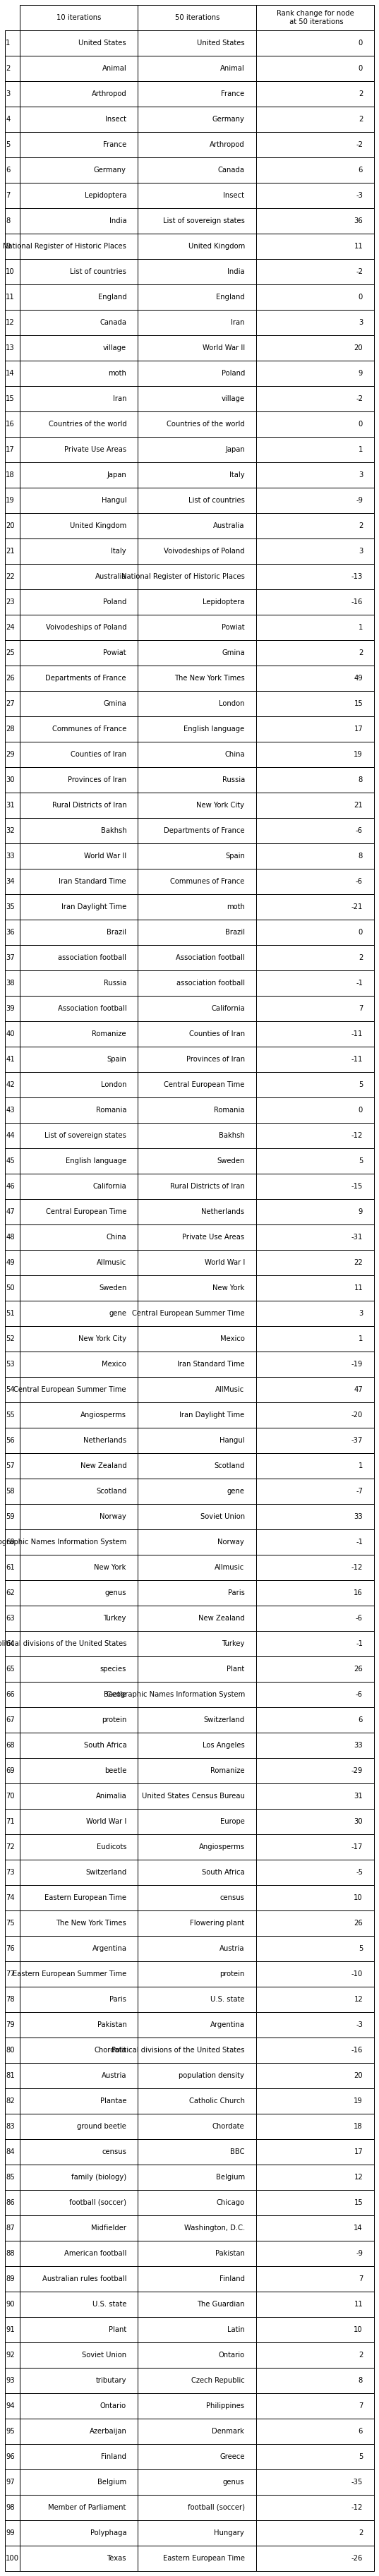

In [2]:
#plot the findings
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ast

colLabels = ["10 iterations","50 iterations", "Rank change for node\n at 50 iterations"]
rowLabels=list(range(1, 101, 1))

#fill in ranking from both iterations
myData = np.empty((100,3), dtype=object)

#variables for storing the node name for 10 and 50 iteration modes
nodenames_10 = []
nodenames_50 = []

#add the node names of top 100 ranked nodes for 10-iteration case to data
with open('result10Itr','r') as nodescores_10runs:
    for i, nodescore_10 in enumerate(nodescores_10runs):
        (nodename_10,score_10) = nodescore_10.split("\t")
        myData[i][0] = nodename_10
        nodenames_10.append(nodename_10)

#add the node names of the top 100 ranked nodes for 50-iteration case to data        
with open('result50Itr','r') as nodescores_50runs:
    for i, nodescore_50 in enumerate(nodescores_50runs):
        (nodename_50,score_50) = nodescore_50.split("\t")
        myData[i][1] = nodename_50
        nodenames_50.append(nodename_50)

for i, nodename_50 in enumerate(nodenames_50):
    if nodename_50 not in nodenames_10:
        myData[i][2] = 100-i
    else:
        index_10 = nodenames_10.index(nodename_50)
        myData[i][2] = index_10-i
        

ax = plt.subplot(111,frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
myTable = plt.table(cellText=myData, rowLabels = rowLabels, colLabels=colLabels, loc='center')

#myTable.scale(3,3)
myTable.auto_set_font_size(False)
myTable.set_fontsize(10)
myTable.scale(3, 3)  # may help
myTable.properties()

#set width
prop = myTable.properties()
cells = prop['child_artists']
for cell in cells:
    cell.set_width(0.5)

plt.show()

> Comment on your findings. 

50 iteration result seem to improve on the on the accuracy of the result compared to the 10 iterations. For example, we see relevant topic such as France bump up in the ranking and irrelvant topic such as Arthropod decline in ranking. 

> Plot both 100 curves.

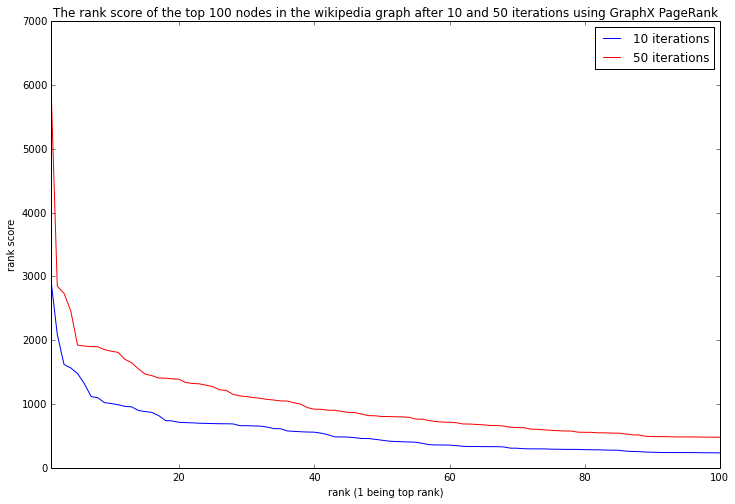

In [6]:
#plot it
%matplotlib inline
import math

#store the log of the rank scores for 10 and 50 iteration cases
score_10_arr=[]
score_50_arr=[]

#add the log(score) of top 100 ranked nodes for 10-iteration case to data
with open('result10Itr','r') as nodescores_10runs:
    for i, nodescore_10 in enumerate(nodescores_10runs):
        (nodename_10,score_10) = nodescore_10.split("\t")
        score_10_arr.append(float(score_10))

#add the log(score) of the top 100 ranked nodes for 50-iteration case to data        
with open('result50Itr','r') as nodescores_50runs:
    for i, nodescore_50 in enumerate(nodescores_50runs):
        (nodename_50,score_50) = nodescore_50.split("\t")
        score_50_arr.append(float(score_50))

#plot graph
ranks = list(range(1, 101, 1)) 
plt.figure(figsize=(12, 8))
plt.title('The rank score of the top 100 nodes in the wikipedia graph after 10 and 50 iterations using GraphX PageRank')
plt.ylabel('rank score')
plt.xlabel('rank (1 being top rank)')
plt.xlim(1,100)
#legend tutorial: http://matplotlib.org/users/legend_guide.html#plotting-guide-legend
line_10,=plt.plot(ranks, score_10_arr, 'b')
line_50,=plt.plot(ranks, score_50_arr, 'r')
plt.legend([line_10, line_50], ['10 iterations', '50 iterations'])
plt.show() 

## Comment

It seems that running more iteration brought more weights to the topics that should get more weights, making ranking more "confident"


>Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

instance-type: m3.xlarge<br/>
instance-count: 6

#### 10 iterations
execution time: ~8 minutes

#### 50 iterations:
execution time: ~30 minutes


>Put the runtime results of HW13.2 and HW13.3 in a tabular format (with rows corresponding to implemention and columns corresponding to experiment setup (10 iterations, 50 iterations)). Discuss the run times and explaing the differences. 

<table>
<tr>
<td><b>Implementation and Environment</b></td>
<td><b>10 iterations</b></td>
<td><b>50 iterations</b></td>
</tr>
<tr>
<td>GraphX PageRank (10 m3.xlarge)
</td>
<td>~8 minutes</td>
<td>~30 minutes</td>
</tr>
<tr>
<td>Home Grown PageRank (6 m3.xlarge)
</td>
<td>~50 minutes</td>
<td>~250 minutes</td>
</tr>
</table>

We believe there is a bug in our Home Grown PageRank, in that it is running 50 iterations even though we are telling it to run only 10 times. This is apparent in the 13.2 result since pageranks are identical between 10 and 50 iterations. We feel this explains why our Home Grown PageRank has such a worse performance compared to GraphX version. 


>Plot the pagerank values for the top 100 pages resulting from the 50 iterations run (using GraphX). Then plot the pagerank values for the same 100 pages that resulted from the 50 iterations run of your homegrown pagerank implemnentation.  

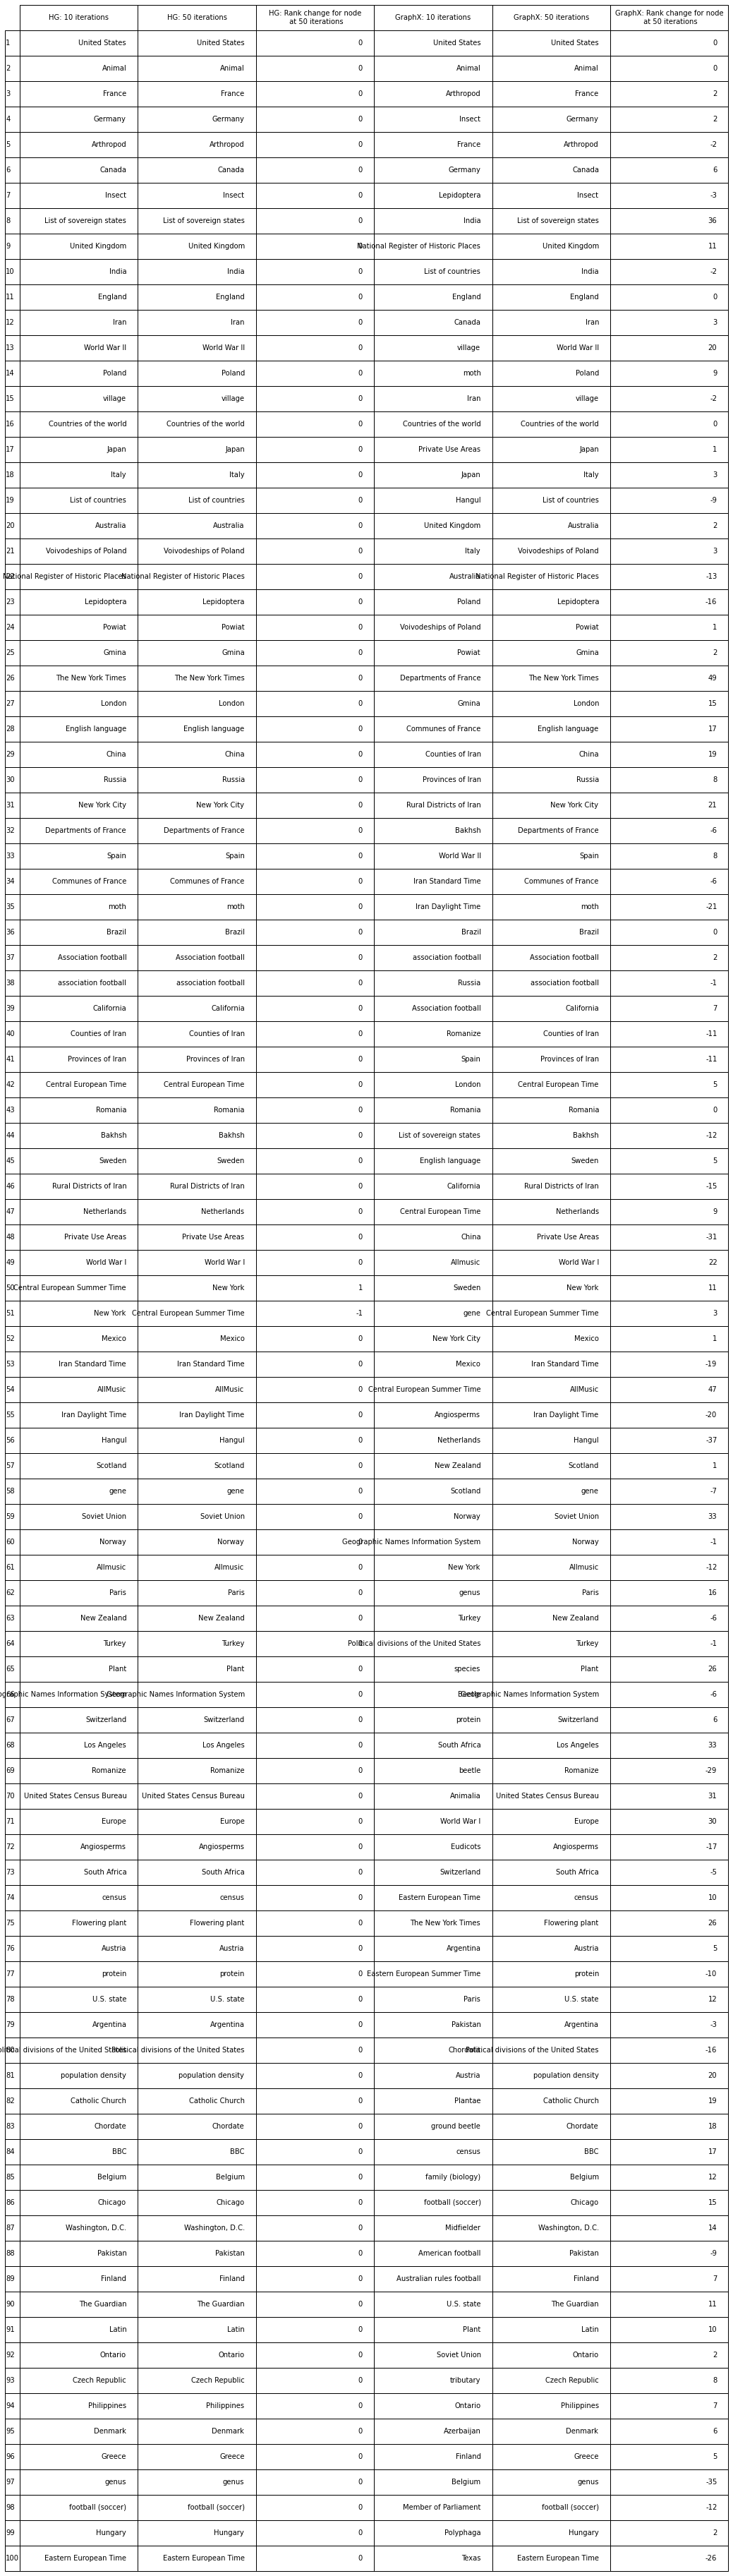

In [10]:
#plot the findings
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ast

colLabels = ["HG: 10 iterations","HG: 50 iterations", "HG: Rank change for node\n at 50 iterations",
            "GraphX: 10 iterations","GraphX: 50 iterations", "GraphX: Rank change for node\n at 50 iterations"]
rowLabels=list(range(1, 101, 1))

#fill in ranking from both iterations
myData = np.empty((100,6), dtype=object)

#variables for storing the node name for 10 and 50 iteration modes
nodenames_10 = []
nodenames_50 = []
nodenames_10_GX = []
nodenames_50_GX = []

#add the node names of top 100 ranked nodes for 10-iteration case to data
with open('nodescore_10runs.txt','r') as nodescores_10runs:
    for i, nodescore_10 in enumerate(nodescores_10runs):
        (nodename_10,score_10) = ast.literal_eval(nodescore_10)
        myData[i][0] = nodename_10
        nodenames_10.append(nodename_10)

#add the node names of the top 100 ranked nodes for 50-iteration case to data        
with open('nodescore_50runs.txt','r') as nodescores_50runs:
    for i, nodescore_50 in enumerate(nodescores_50runs):
        (nodename_50,score_50) = ast.literal_eval(nodescore_50)
        myData[i][1] = nodename_50
        nodenames_50.append(nodename_50)
        
#GraphX add the node names of top 100 ranked nodes for 10-iteration case to data
with open('result10Itr','r') as nodescores_10runs:
    for i, nodescore_10 in enumerate(nodescores_10runs):
        (nodename_10,score_10) = nodescore_10.split("\t")
        myData[i][3] = nodename_10
        nodenames_10_GX.append(nodename_10)

#GraphX add the node names of the top 100 ranked nodes for 50-iteration case to data        
with open('result50Itr','r') as nodescores_50runs:
    for i, nodescore_50 in enumerate(nodescores_50runs):
        (nodename_50,score_50) = nodescore_50.split("\t")
        myData[i][4] = nodename_50
        nodenames_50_GX.append(nodename_50)

#homegrown calculate the diff
for i, nodename_50 in enumerate(nodenames_50):
    if nodename_50 not in nodenames_10:
        myData[i][2] = 100-i
    else:
        index_10 = nodenames_10.index(nodename_50)
        myData[i][2] = index_10-i
        
for i, nodename_50 in enumerate(nodenames_50_GX):
    if nodename_50 not in nodenames_10_GX:
        myData[i][5] = 100-i
    else:
        index_10 = nodenames_10_GX.index(nodename_50)
        myData[i][5] = index_10-i
        

ax = plt.subplot(111,frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
myTable = plt.table(cellText=myData, rowLabels = rowLabels, colLabels=colLabels, loc='center')

#myTable.scale(3,3)
myTable.auto_set_font_size(False)
myTable.set_fontsize(10)
myTable.scale(3, 3)  # may help
myTable.properties()

#set width
prop = myTable.properties()
cells = prop['child_artists']
for cell in cells:
    cell.set_width(0.5)

plt.show()

 >Comment on your findings.  Have the top 100 ranked pages changed? Have the pagerank values changed? Explain.

 
It seems that homegrown pagrank after both 10 and 50 iterations match result from 50 iterations using GraphX PageRank. This means that our homegrown algorithm itself is identical to the GraphX version in terms of validity. However, as we stated as above, had we had more time we will investigate why our homegrown pagerank seems to be running 50 iterations when we tell it to run 10 iterations. 
 

# HW 13.4: Criteo Phase 2 Baseline
>SPECIAL NOTE:
Please share your findings as they become available with the class via the Google Group. You will get brownie points for this.  Once results are shared, please use them and build on them.

>The  Criteo data is located in the following S3 bucket:  criteo-dataset 
https://console.aws.amazon.com/s3/home?region=us-west-1#&bucket=criteo-dataset&prefix=

>Using the training dataset, validation dataset, and testing dataset in the Criteo bucket, perform the following experiment:

>Write spark code (borrow from Phase 1 of this project) to train a logistic regression model with the following hyperparameters:

> - Number of buckets for hashing: 1,000
 - Logistic Regression: no regularization term
 - Logistic Regression: step size = 10

>Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

>Report in tabular form the AUC value (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the Training, Validation, and Testing datasets.  Report in tabular form  the logLossTest for the Training, Validation, and Testing datasets.

>Dont forget to put a caption on your tables (above each table).

## 13.4.1  Define Functions for Running Logistic Regression for Criteo Phase 2

In [200]:
%%writefile criteo_phase2.py
#!/usr/bin/env python
import sys
from pyspark import SparkContext
import numpy as np
from math import log
from math import exp
import hashlib
from collections import defaultdict
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.classification import LogisticRegressionWithSGD
import csv
import ast
import json
import time

def hashFunction(numBuckets, rawFeats, printMapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use printMapping=True for debug purposes and to better understand how the hashing works.

    Args:
        numBuckets (int): Number of buckets to use as features.
        rawFeats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        printMapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = {}
    for ind, category in rawFeats:
        featureString = category + str(ind)
        mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)
    if(printMapping): print mapping
    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    
    return dict(sparseFeatures)


def parseHashPoint(point, numBuckets):
    """Create a LabeledPoint for this observation using hashing.

    Args:
        point (str): A comma separated string where the first value is the label and the rest are
            features.
        numBuckets: The number of buckets to hash to.

    Returns:
        LabeledPoint: A LabeledPoint with a label (0.0 or 1.0) and a SparseVector of hashed
            features.
    """
    values = [x for x in point.split(",")]
    num_features = len(values) - 1
    x = []
    for i in range(num_features):
        x.append((i, values[i+1]))
    features = SparseVector(numBuckets,hashFunction(numBuckets, x, False))
        
    return LabeledPoint(values[0], features)


def getP(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.

    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.

    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.

    Returns:
        float: A probability between 0 and 1.
    """
    rawPrediction = x.dot(w) + intercept

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    
    return 1.0/(1 + exp(-1.0*rawPrediction))


def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probability and label.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.

    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.

    Returns:
        float: The log loss value.
    """
    epsilon = 10e-12
    p = np.maximum(epsilon, p)
    p = np.minimum(1-epsilon, p)
    logLoss = y*np.log(p) + (1 - y)*np.log(1 - p)
    logLoss = logLoss * -1.0
    
    return logLoss


def evaluateResults(model, data):
    """Calculates the log loss and AUC for the data given the model.

    Args:
        model (LogisticRegressionModel): A trained logistic regression model.
        data (RDD of LabeledPoint): Labels and features for each observation.

    Returns:
        float: Log loss for the data.
    """
    predictionWithLabel = (data.map(lambda x: (getP(x.features, model.weights, model.intercept), x.label)))
    logLoss     = (predictionWithLabel
                   .map(lambda x: computeLogLoss(x[0], x[1]))
                   .reduce(lambda a, b: a + b)
                  )/predictionWithLabel.count()
    metrics = BinaryClassificationMetrics(predictionWithLabel)
    auc = metrics.areaUnderROC
    
    return logLoss, auc


def main_lr_model(input_train, input_val, input_test, output_file, splitData, hashData,  \
                  numHashBuckets, stepSizes, regParams, regType, includeIntercept):

    if splitData == 'True':
        splitData = True
    else:
        splitData = False
    if hashData == 'True':
        hashData = True
    else:
        hashData = False
    if regType == 'None':
        regType = None
    if includeIntercept == 'True':
        includeIntercept = True
    else:
        includeIntercept = False
      
    # get data from file, split if splitData = True, hash if hashData = True
    
    # read in train data
    # work with either ',' or '\t' separated data
    rawTrainData = (sc.textFile(input_train).map(lambda x: x.replace('\t', ',')))
    rawTrainData.cache()
    
    if input_val != 'None':
        rawValidationData = (sc.textFile(input_val).map(lambda x: x.replace('\t', ',')))
        rawValidationData.cache()
    
    if input_test != 'None':
        rawTestData = (sc.textFile(input_test).map(lambda x: x.replace('\t', ',')))
        rawTestData.cache()
    
    if splitData == True or input_val == 'None' or input_test == 'None':
        
        # split the raw data into training, validation, and test datasets
        weights = [.8, .1, .1]
        seed = 42

        rawTrainData, rawValidationData, rawTestData = rawTrainData.randomSplit(weights, seed)
        rawTrainData.cache()
        rawValidationData.cache()
        rawTestData.cache()

#     final_outputs=[]
    final_outputs=sc.emptyRDD()
    run_count = 0
        
    if hashData == True:
#         for i in range(numHashBuckets_start, numHashBuckets_end, numHashBuckets_incr):
        for numHashBucket in numHashBuckets:

            # hash the data
            hashTrainData = rawTrainData.map(lambda point: parseHashPoint(point,numHashBucket))
            hashTrainData.cache()
            hashValidationData = rawValidationData.map(lambda point: parseHashPoint(point,numHashBucket))
            hashValidationData.cache()
            hashTestData = rawTestData.map(lambda point: parseHashPoint(point,numHashBucket))
            hashTestData.cache()

#             for j in range(stepSize_start, stepSize_end, stepSize_incr):
            for stepSize in stepSizes:

#                 for regParam in range(0, regParam_iterations, 1):
#                     regParam = 1.0*regParam_start + 1.0*regParam_incr*k     
                for regParam in regParams:
        
                    # test hyperparameters: stepSize, regParam, regType, includeIntercept
                    # output: log loss and AUC for training, validation, and test datasets
                        
                    # build logistic regression model
                    model = (LogisticRegressionWithSGD
                                .train(hashTrainData, step = stepSize, regParam = regParam,  \
                                       regType=regType, intercept=includeIntercept))

                    # evaluate the model
                    logLossTrain, aucTrain = evaluateResults(model, hashTrainData)
                    logLossVal, aucVal = evaluateResults(model, hashValidationData)
                    logLossTest, aucTest = evaluateResults(model, hashTestData)
    
#                     output_line = [i, j, regParam, regType, includeIntercept, logLossTrain, aucTrain]
#                     output_line = [numHashBucket,stepSize, regParam, regType, includeIntercept, logLossTrain, aucTrain]
#                     output_line = output_line + [logLossVal, aucVal, logLossTest, aucTest]
                    output_line = (stepSize, regParam, regType, includeIntercept, logLossTrain, 
                                   aucTrain,logLossVal, aucVal, logLossTest, aucTest)

#                     with open(output_file, 'a+') as f:
#                         writer = csv.writer(f)
#                         writer.writerow(output_line)
                    run_count+=1               
#                     final_outputs.append((run_count,output_line))
#                     final_outputs.append((run_count,output_line))
                    output_rdd = sc.parallelize([(run_count,output_line)])
                    final_outputs = final_outputs.union(output_rdd)
                        
    else:
#         for j in range(stepSize_start, stepSize_end, stepSize_incr):
        for stepSize in stepSizes:
        
#             for k in range(0, regParam_iterations, 1):
#                 regParam = 1.0*regParam_start + 1.0*regParam_incr*k
            for regParam in regParams:
                        
                # test hyperparameters: stepSize, regParam, regType, includeIntercept
                # output: log loss and AUC for training, validation, and test datasets
                        
                # build logistic regression model
                model = (LogisticRegressionWithSGD
                            .train(hashTrainData, step = stepSize, regParam = regParam,  \
                                   regType=regType, intercept=includeIntercept))

                # evaluate the model
                logLossTrain, aucTrain = evaluateResults(model, hashTrainData)
                logLossVal, aucVal = evaluateResults(model, hashValidationData)
                logLossTest, aucTest = evaluateResults(model, hashTestData)
    

#                 output_line = [i, j, regParam, regType, includeIntercept, logLossTrain, aucTrain]
#                 output_line = [stepSize, regParam, regType, includeIntercept, logLossTrain, aucTrain]
#                 output_line = output_line + [logLossVal, aucVal, logLossTest, aucTest]
                output_line = (stepSize, regParam, regType, includeIntercept, logLossTrain, 
                               aucTrain,logLossVal, aucVal, logLossTest, aucTest)

#                 with open(output_file, 'a+') as f:
#                     writer = csv.writer(f)
#                     writer.writerow(output_line)
                
                run_count+=1               
#                 final_outputs.append((run_count,output_line))
#                 final_outputs.append((run_count,output_line))
                output_rdd = sc.parallelize([(run_count,output_line)])
                final_outputs = final_outputs.union(output_rdd)



    #save output
    final_outputs.sortByKey(True).coalesce(1).saveAsTextFile(output_file)

    return


if __name__ == "__main__":
    
#     if len(sys.argv) < 17:
#         print >> sys.stderr, "You have not entered all 17 parameters required.  Please try again."
#         exit(-1)

#     input_train          = sys.argv[1]
#     input_val            = sys.argv[2]
#     input_test           = sys.argv[3]
#     output_file          = sys.argv[4]
#     splitData            = sys.argv[5]
#     hashData             = sys.argv[6]
#     numHashBuckets_start = int(sys.argv[7])
#     numHashBuckets_end   = int(sys.argv[8])
#     numHashBuckets_incr  = int(sys.argv[9])
#     stepSize_start       = int(sys.argv[10])
#     stepSize_end         = int(sys.argv[11])
#     stepSize_incr        = int(sys.argv[12])
#     regParam_start       = float(sys.argv[13])
#     regParam_incr        = float(sys.argv[14])
#     regParam_iterations  = int(sys.argv[15])
#     regType              = sys.argv[16]
#     includeIntercept     = sys.argv[17]

#     sc = SparkContext(appName="criteo_phase2")

#     main_lr_model(input_train, input_val, input_test, output_file, splitData, hashData,  \
#                   numHashBuckets_start, numHashBuckets_end, numHashBuckets_incr,         \
#                   stepSize_start, stepSize_end, stepSize_incr,                           \
#                   regParam_start, regParam_incr, regParam_iterations,                    \
#                   regType, includeIntercept) 

#     with open(sys.argv[1]) as data:    
#         input_data = json.load(data)


    #obtain data from json input
    sc = SparkContext(appName="criteo_phase2") 
    
    input_data = sc.textFile(sys.argv[1]).map(lambda line: json.loads(line)).collect()[0]
 
    if input_data["splitData"]=="True": input_data["splitData"]==True
    else: input_data["splitData"]=False
    
    if input_data["hashData"]=="True": input_data["hashData"]==True
    else: input_data["hashData"]=False
        
    if input_data["regType"]=="None": input_data["regType"]=None

    if input_data["includeIntercept"]=="True": input_data["includeIntercept"]==True
    else: input_data["includeIntercept"]=False    

#     #run model on Spark
#     sc = SparkContext(appName="criteo_phase2")
#     main_lr_model(input_data["input_train"], 
#                   input_data["input_val"], 
#                   input_data["input_test"], 
#                   input_data["output_file"], 
#                   input_data["splitData"], 
#                   input_data["hashData"],
#                   input_data["numHashBuckets_start"], 
#                   input_data["numHashBuckets_end"], 
#                   input_data["numHashBuckets_incr"],
#                   input_data["stepSize_start"], 
#                   input_data["stepSize_end"], 
#                   input_data["stepSize_incr"],
#                   input_data["regParam_start"], 
#                   input_data["regParam_incr"], 
#                   input_data["regParam_iterations"],
#                   input_data["regType"], 
#                   input_data["includeIntercept"]
#     )

    main_lr_model(input_data["input_train"], 
                  input_data["input_val"], 
                  input_data["input_test"], 
                  input_data["output_file"], 
                  input_data["splitData"], 
                  input_data["hashData"],
                  input_data["numHashBuckets"],
                  input_data["stepSize"],
                  input_data["regParam"],
                  input_data["regType"], 
                  input_data["includeIntercept"]
    )

    sc.stop()


        

Overwriting criteo_phase2.py


In [189]:
final_outputs = sc.emptyRDD()

output1 = sc.parallelize([(1,("a","b","c"))])
output2 = sc.parallelize([(2,("d","e","f"))])
# final_outputs = output1.union(output2)

final_outputs = final_outputs.union(output1)
final_outputs.collect()
final_outputs = final_outputs.union(output2)
final_outputs.collect()



# final_outputs.groupByKey(output1)
# .fullOuterJoin(output2)
# final_outputs.collect()

[1, ('a', 'b', 'c'), 2, ('d', 'e', 'f')]

## 13.4.2 Run Criteo Phase 2 with Small Test Dataset Locally (No Regularization)

We will first do dry run with very small data set with various number of buckets, reg params, etc.. to make sure code works.

In [155]:
%%writefile 13_4_dummy_local.json
{
    "input_train"      : "dac_sample.txt",
    "input_val"        : "None",
    "input_test"       : "None",
    "output_file"      : "13_4/output_dummy_local/",
    "splitData"        : "True",
    "hashData"         : "True",
    "numHashBuckets"   : [1000],
    "stepSize"         : [100],
    "regParam"         : [1e-3],
    "regType"          : "None",
    "includeIntercept" : "True"
}

Overwriting 13_4_dummy_local.json


In [196]:
#must minify the json file so that it is a single line in order to be fed into Spark
!python -m jsmin 13_4_dummy_local.json > 13_4_dummy_local_mini.json

In [197]:
# ensure folder with output name does not exist
!rm -r 13_4/output_dummy_local 

#submit spark job
!time /Users/maktrix/Dropbox/Berkeley/W261_ML_scale/spark-1.5.1-bin-hadoop2.6/bin/spark-submit ./criteo_phase2.py 13_4_dummy_local_mini.json 
    
# output results:
# results are: numHashBuckets, stepSize, regParam, regType, includeIntercept, logLossTrain, aucTrain,
#              logLossValidation, aucValidation, logLossTest, aucTest
# !rm 13_4/local_output/_SUCCESS
!echo 'Output is in the form: (numHashBuckets, (stepSize, regParam, regType, includeIntercept, logLossTrain, aucTrain, \
              logLossValidation, aucValidation, logLossTest, aucTest))'
!echo '-----------------OUTPUT-----------------'
!cat 13_4/output_dummy_local/part-00000

15/12/09 01:50:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
15/12/09 01:50:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
15/12/09 01:50:05 WARN MetricsSystem: Using default name DAGScheduler for source because spark.app.id is not set.
15/12/09 01:50:28 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
15/12/09 01:50:28 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS

real	2m43.320s
user	2m1.170s
sys	0m6.863s
Output is in the form: (numHashBuckets, (stepSize, regParam, regType, includeIntercept, logLossTrain, aucTrain,               logLossValidation, aucValidation, logLossTest, aucTest))
-----------------OUTPUT-----------------
(1, (10, 1e-06, None, True, 0.46420700188039676, 0.7466607435940702, 0.46366004113163489, 0.7387534687240719, 0.47165704683646048, 0.7351873227083543))
(2, (10, 0.001

## 13.4.3  Run Criteo Phase 2 with Small Test Dataset on EMR Cluster (no regularization)

In [28]:
#create cluster
!aws emr create-cluster --name "13_4" --release-label emr-4.2.0 --applications Name=Spark --instance-count 10 --use-default-roles --ec2-attributes KeyName=w261_key2 --instance-type m3.xlarge  --enable-debugging --log-uri s3://ucb-mids-mls-group-e/hw13 --configurations file://./emr_config_spark_max.json

j-1UQRII41XJHDX


In [140]:
%%writefile 13_4_dummy_emr.json
{
    "input_train"      : "s3n://ucb-mids-mls-group-e/hw13/13_4/dac_sample.txt",
    "input_val"        : "None",
    "input_test"       : "None",
    "output_file"      : "s3n://ucb-mids-mls-group-e/hw13/13_4/output_dummy_emr",
    "splitData"        : "True",
    "hashData"         : "True",
    "numHashBuckets"   : [1000,10000],
    "stepSize"         : [10,100],
    "regParam"         : [1e-6, 1e-3],
    "regType"          : "None",
    "includeIntercept" : "True"
}

Overwriting 13_4_dummy_emr.json


In [142]:
#must minify the json file so that it is a single line in order to be fed into Spark
!python -m jsmin 13_4_dummy_emr.json > 13_4_dummy_emr_mini.json

In [144]:
#copy dummy small test data and json input file to s3
!aws s3 cp dac_sample.txt s3://ucb-mids-mls-group-e/hw13/13_4/dac_sample.txt
!aws s3 cp 13_4_dummy_emr_mini.json s3://ucb-mids-mls-group-e/hw13/13_4/13_4_dummy_emr_mini.json

upload: ./dac_sample.txt to s3://ucb-mids-mls-group-e/hw13/13_4/dac_sample.txt
upload: ./13_4_dummy_emr_mini.json to s3://ucb-mids-mls-group-e/hw13/13_4/13_4_dummy_emr_mini.json


In [202]:
#copy main pyspark file to emr cluster
!scp -i /Users/maktrix/Dropbox/Berkeley/W261_ML_scale/w261_key2.pem criteo_phase2.py hadoop@ec2-52-33-135-218.us-west-2.compute.amazonaws.com:code/.

criteo_phase2.py                              100%   14KB  14.2KB/s   00:00    


In [ ]:
#make sure output folder of same name does not exist
!aws s3 rm --recursive s3://ucb-mids-mls-group-e/hw13/13_4/output_dummy_emr

#### Run job on EMR by ssh into the cluster and submit spark job with below commands:
- ssh -i w261_key2.pem hadoop@ec2-52-11-63-26.us-west-2.compute.amazonaws.com
- time /usr/lib/spark/bin/spark-submit --master yarn-cluster ./code/criteo_phase2.py s3n://ucb-mids-mls-group-e/hw13/13_4/13_4_dummy_emr_mini.json

In [203]:
#remove local output folder of same name
!rm -r 13_4/output_dummy_emr

#get output from S3 (note that there is only one partition because of spark's colesce function
!aws s3 cp --recursive s3://ucb-mids-mls-group-e/hw13/13_4/output_dummy_emr 13_4/output_dummy_emr
    
!echo 'Output is in the form: (numHashBuckets, (stepSize, regParam, regType, includeIntercept, logLossTrain, aucTrain, \
              logLossValidation, aucValidation, logLossTest, aucTest))'
!echo '-----------------OUTPUT-----------------'
!cat 13_4/output_dummy_emr/part-00000


download: s3://ucb-mids-mls-group-e/hw13/13_4/output_dummy_emr/_SUCCESS to 13_4/output_dummy_emr/_SUCCESS
download: s3://ucb-mids-mls-group-e/hw13/13_4/output_dummy_emr/part-00000 to 13_4/output_dummy_emr/part-00000
Output is in the form: (numHashBuckets, (stepSize, regParam, regType, includeIntercept, logLossTrain, aucTrain,               logLossValidation, aucValidation, logLossTest, aucTest))
-----------------OUTPUT-----------------
(1, (10, 9.9999999999999995e-07, None, True, 0.46420700188039676, 0.74666074359407864, 0.46366004113163489, 0.73875346872407011, 0.47165704683646043, 0.73518732270835574))
(2, (10, 0.001, None, True, 0.46420700188039676, 0.74666074359407808, 0.46366004113163489, 0.73875346872406988, 0.47165704683646043, 0.73518732270835585))
(3, (100, 9.9999999999999995e-07, None, True, 2.5322448153076667, 0.74648880111732496, 2.6251501084940876, 0.73564068908640778, 2.6037791705678952, 0.73452338416825214))
(4, (100, 0.001, None, True, 2.5322448153076667, 0.746488801117

## 13.4.4  Run Criteo Phase 2 with Full Dataset on EMR Cluster (no regularization)

In [208]:
%%writefile 13_4_full_emr.json
{
    "input_train"      : "s3n://criteo-dataset/rawdata/train",
    "input_val"        : "s3n://criteo-dataset/rawdata/validation",
    "input_test"       : "s3n://criteo-dataset/rawdata/test",
    "output_file"      : "s3n://ucb-mids-mls-group-e/hw13/13_4/output_full_emr",
    "splitData"        : "False",
    "hashData"         : "True",
    "numHashBuckets"   : [1000],
    "stepSize"         : [10],
    "regParam"         : [1e-6],
    "regType"          : "None",
    "includeIntercept" : "True"
}

Overwriting 13_4_full_emr.json


In [210]:
#must minify the json file so that it is a single line in order to be fed into Spark
!python -m jsmin 13_4_full_emr.json > 13_4_full_emr_mini.json

#copy json input file to s3
!aws s3 cp 13_4_full_emr_mini.json s3://ucb-mids-mls-group-e/hw13/13_4/13_4_full_emr_mini.json
    
#copy main PySpark file into EMR master node
!scp -i /Users/maktrix/Dropbox/Berkeley/W261_ML_scale/w261_key2.pem criteo_phase2.py hadoop@ec2-52-33-135-218.us-west-2.compute.amazonaws.com:code/.

#make sure no output folder of same name exist
!aws s3 rm --recursive s3://ucb-mids-mls-group-e/hw13/13_4/output_full_emr

upload: ./13_4_full_emr_mini.json to s3://ucb-mids-mls-group-e/hw13/13_4/13_4_full_emr_mini.json
criteo_phase2.py                              100%   14KB  14.2KB/s   00:00    


#### Run job on EMR by ssh into the cluster and submit spark job with below commands:
- ssh -i w261_key2.pem hadoop@ec2-52-11-63-26.us-west-2.compute.amazonaws.com
- time /usr/lib/spark/bin/spark-submit --master yarn-cluster ./code/criteo_phase2.py s3n://ucb-mids-mls-group-e/hw13/13_4/13_4_full_emr_mini.json

real	32m5.550s  
user	0m10.396s  
sys	0m1.312s  

In [2]:
#remove local output folder of same name
!rm -r 13_4/output_full_emr

#get output from S3 (note that there is only one partition because of spark's colesce function
!aws s3 cp --recursive s3://ucb-mids-mls-group-e/hw13/13_4/output_full_emr 13_4/output_full_emr
    
!echo 'Output is in the form: (numHashBuckets, (stepSize, regParam, regType, includeIntercept, logLossTrain, aucTrain, \
              logLossValidation, aucValidation, logLossTest, aucTest))'
!echo '-----------------OUTPUT-----------------'
!cat 13_4/output_full_emr/part-00000


download: s3://ucb-mids-mls-group-e/hw13/13_4/output_full_emr/_SUCCESS to 13_4/output_full_emr/_SUCCESS
download: s3://ucb-mids-mls-group-e/hw13/13_4/output_full_emr/part-00000 to 13_4/output_full_emr/part-00000
Output is in the form: (numHashBuckets, (stepSize, regParam, regType, includeIntercept, logLossTrain, aucTrain,               logLossValidation, aucValidation, logLossTest, aucTest))
-----------------OUTPUT-----------------
(1, (10, 9.9999999999999995e-07, None, True, 0.50546399695096322, 0.72454929493843867, 0.50567611207609031, 0.72432606212044237, 0.50560280035162408, 0.72479664734688976))


## 13.4.5 Report Results
This is the final result of the actual EMR run on the full set of Criteo data. We used the raw data (NOT the preprocessed data) so that we can hash it to 1000 buckets. The main task for hw13.4 includes the following configurations:
-    "input_train"      : "s3n://criteo-dataset/rawdata/train",
-    "input_val"        : "s3n://criteo-dataset/rawdata/validation",
-    "input_test"       : "s3n://criteo-dataset/rawdata/test",
-    "output_file"      : "s3n://ucb-mids-mls-group-e/hw13/13_4/output_full_emr",
-    "splitData"        : "False",
-    "hashData"         : "True",
-    "numHashBuckets"   : [1000],
-    "stepSize"         : [10],
-    "regParam"         : [1e-6],
-    "regType"          : "None",
-    "includeIntercept" : "True"

In [4]:
from prettytable import PrettyTable

x = PrettyTable(["Data", "Log Loss", "AUC"])
# x.align["City name"] = "l" # Left align city names
x.padding_width = 1 # One space between column edges and contents (default)
x.add_row(["Train",0.5055, 0.7245])
x.add_row(["Validation",0.5057, 0.7243])
x.add_row(["Test", 0.5056, 0.7248])
print x


+------------+----------+--------+
|    Data    | Log Loss |  AUC   |
+------------+----------+--------+
|   Train    |  0.5055  | 0.7245 |
| Validation |  0.5057  | 0.7243 |
|    Test    |  0.5056  | 0.7248 |
+------------+----------+--------+


The EMR cluster configuration is as follow:
- instance-type: m3.xlarge  
- instance-count: 10
- region: us-west-2
- execution time: 32m5.550s \*

\* We used the elapsed real time between command line invocation and termination as our time benchmark for execution time

# HW 13.5: Criteo Phase 2 Hyperparameter Tuning
>SPECIAL NOTE:
Please share your findings as they become available with class via the Google Group. You will get brownie points for this.  Once results are shared please used them and build on them.

>NOTE:  please do  HW 13.5 in groups of 3 

>Using the training dataset, validation dataset and testing dataset in the Criteo bucket perform the following experiments:

>-- write spark code (borrow from Phase 1 of this project) to train a logistic regression model with various hyperparamters. Do a gridsearch of the hyperparameter space and determine optimal settings using the validation set.

>-- Number of buckets for hashing: 1,000, 10,000, .... explore different values  here
-- Logistic Regression: regularization term: [1e-6, 1e-3]  explore other  values here also
-- Logistic Regression: step size: explore different step sizes. Focus on a stepsize of 1 initially. 

>Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

>Report in tabular form and using heatmaps the AUC values (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the Training, Validation, and Testing datasets.
Report in tabular form and using heatmaps  the logLossTest for the Training, Validation, and Testing datasets.

>Dont forget to put a caption on your tables (above the table) and on your heatmap figures (put caption below figures) detailing the experiment associated with each table or figure (data, algorithm used, parameters and settings explored.

>Discuss the optimal setting to solve this problem  in terms of the following:
-- Features
-- Learning algortihm
-- Spark cluster

>Justiy your recommendations based on your experimental results and cross reference with table numbers and figure numbers. Also highlight key results with annotations, both textual and line and box based, on your tables and graphs.


In [68]:
#create cluster
!aws emr create-cluster --name "13_5" --release-label emr-4.2.0 --applications Name=Spark --instance-count 22 --use-default-roles --ec2-attributes KeyName=w261_key2 --instance-type m3.xlarge  --enable-debugging --log-uri s3://ucb-mids-mls-group-e/hw13 --configurations file://./emr_config_spark_max.json

j-1MJBN9W88ONM2


In [213]:
%%writefile 13_5_full_emr.json
{
    "input_train"      : "s3n://criteo-dataset/rawdata/train",
    "input_val"        : "s3n://criteo-dataset/rawdata/validation",
    "input_test"       : "s3n://criteo-dataset/rawdata/test",
    "output_file"      : "s3n://ucb-mids-mls-group-e/hw13/13_5",
    "splitData"        : "False",
    "hashData"         : "True",
    "numHashBuckets"   : [1000,10000, 50000, 100000],
    "stepSize"         : [1, 10, 50, 100],
    "regParam"         : [1e-6, 1e-3, 1e-1],
    "regType"          : "l2",
    "includeIntercept" : "True"
}


Overwriting 13_5_full_emr.json


### must minify the json file so that it is a single line in order to be fed into Spark
!python -m jsmin 13_5_full_emr.json > 13_5_full_emr_mini.json

### copy json input file to s3
!aws s3 cp 13_5_full_emr_mini.json s3://ucb-mids-mls-group-e/hw13/13_5/13_5_full_emr_mini.json

### copy main PySpark file into EMR master node
!scp -i /Users/maktrix/Dropbox/Berkeley/W261_ML_scale/w261_key2.pem criteo_phase2.py hadoop@ec2-52-33-226-49.us-west-2.compute.amazonaws.com:code/.

### make sure no output folder of same name exist
!aws s3 rm --recursive s3://ucb-mids-mls-group-e/hw13/13_5/output_full_emr

#### Run job on EMR by ssh into the cluster and submit spark job with below commands:
- ssh -i w261_key2.pem hadoop@ec2-52-33-226-49.us-west-2.compute.amazonaws.com
- time /usr/lib/spark/bin/spark-submit --master yarn-cluster ./code/criteo_phase2.py s3n://ucb-mids-mls-group-e/hw13/13_5/13_5_full_emr_mini.json

In [ ]:
#remove local output folder of same name
!rm -r 13_5/output_full_emr

#get output from S3 (note that there is only one partition because of spark's colesce function
!aws s3 cp --recursive s3://ucb-mids-mls-group-e/hw13/13_5/output_full_emr 13_5/output_full_emr
    
!echo 'Output is in the form: (numHashBuckets, (stepSize, regParam, regType, includeIntercept, logLossTrain, aucTrain, \
              logLossValidation, aucValidation, logLossTest, aucTest))'
!echo '-----------------OUTPUT-----------------'
!cat 13_5/output_full_emr/part-00000



## 13.5.2 Report Results

#### First we calculated which setting produced the highest AUC and lowest logloss. 

In [110]:

        
allResults=[]

#variable for all of the mimimum/maximum and setting
#format:
#(value, num of buckets, stepSize, regParam)
LogLossTrainMin=(1000,0,0,0)
AUCTrainMax=(0,0,0,0)

LogLossValMin = (1000,0,0,0)
AUCValMax =(0,0,0,0)

LogLossTestMin = (1000,0,0,0)
AUCTestMax = (0,0,0,0)

index =0
with open("part-00000-FIXED") as f:
    for line in f.readlines():  
        
        #format (0'numHashBuckets', 1'stepSize', 2'regParam', 3'regType', 
        #4'includeIntercept', 5'logLossTrain', 6'aucTrain', 7'logLossValidation', 
        #8'aucValidation', 9'logLossTest', 10'aucTest')

        if (index != 0): # skip the header row
            res = ast.literal_eval(line)[1]
            
            #replace min/max
            if res[5] < LogLossTrainMin[0]:
                LogLossTrainMin = (res[5],res[0],res[1],res[2])
                
            if res[6] > AUCTrainMax[0]:
                AUCTrainMax = (res[6],res[0],res[1],res[2])
                
            if res[7] < LogLossValMin[0]:
                LogLossValMin = (res[7],res[0],res[1],res[2])
                
            if res[8] > AUCValMax[0]:
                AUCValMax = (res[8],res[0],res[1],res[2])
                
            if res[9] < LogLossTestMin[0]:
                LogLossTestMin = (res[9],res[0],res[1],res[2])
                
            if res[10] > AUCTestMax[0]:
                AUCTestMax = (res[10],res[0],res[1],res[2])
        index+=1
print LogLossTrainMin

print LogLossValMin

print LogLossTestMin


print AUCTrainMax
print AUCValMax
print AUCTestMax

(0.49686888930472667, 100000, 10, 1e-06)
(0.4970421423568774, 100000, 10, 1e-06)
(0.49704914524132404, 100000, 10, 1e-06)
(0.743856809408394, 50000, 50, 1e-06)
(0.7436810169467475, 50000, 50, 1e-06)
(0.743915770068778, 50000, 50, 1e-06)


####  Minimum Logloss


In [111]:
from prettytable import PrettyTable

x = PrettyTable(["Data", "Minimum Log Loss", "Hash Bucket Size","Step Size", "Reg Param"])
# x.align["City name"] = "l" # Left align city names
x.padding_width = 1 # One space between column edges and contents (default)
x.add_row(["Train",0.4969, 100000, 10,1e-06])
x.add_row(["Validation",0.4970, 100000, 10,1e-06])
x.add_row(["Test", 0.4970, 100000, 10,1e-06])
print x

+------------+------------------+------------------+-----------+-----------+
|    Data    | Minimum Log Loss | Hash Bucket Size | Step Size | Reg Param |
+------------+------------------+------------------+-----------+-----------+
|   Train    |      0.4969      |      100000      |     10    |   1e-06   |
| Validation |      0.497       |      100000      |     10    |   1e-06   |
|    Test    |      0.497       |      100000      |     10    |   1e-06   |
+------------+------------------+------------------+-----------+-----------+


####  Maximum AUC

In [114]:
from prettytable import PrettyTable

x = PrettyTable(["Data", "Maximum AUC", "Hash Bucket Size","Step Size", "Reg Param"])
# x.align["City name"] = "l" # Left align city names
x.padding_width = 1 # One space between column edges and contents (default)
x.add_row(["Train",0.7439, 50000, 50,1e-06])
x.add_row(["Validation",0.7437, 50000, 50,1e-06])
x.add_row(["Test", 0.7439, 50000, 50,1e-06])
print x

+------------+-------------+------------------+-----------+-----------+
|    Data    | Maximum AUC | Hash Bucket Size | Step Size | Reg Param |
+------------+-------------+------------------+-----------+-----------+
|   Train    |    0.7439   |      50000       |     50    |   1e-06   |
| Validation |    0.7437   |      50000       |     50    |   1e-06   |
|    Test    |    0.7439   |      50000       |     50    |   1e-06   |
+------------+-------------+------------------+-----------+-----------+


#### Final Results:
We use the final AUC results to determine the optimal settings for solving this problem:
 - Features:  50,000 (i.e. # of hash buckets)
 - Learning Algorithm:  Step size of 50, Regularization parameter of 1e-06.
 
Our final AWS configuration: 
 - instance-type: m3.xlarge
 - instance-count 22
 - region us-west-2
 
Run time:
 - real:  243m29.296s
 - user:  0m26.556s
 - sys:   0m4.536s

### Code for creating table for each result and heatmaps

<b>( Note: We created a separate heatmap and table per hash bucket. )</b>

In [69]:
import ast
import numpy as np
from matplotlib.colors import LinearSegmentedColormap


#load result in the array of tuples
resultData = []

#create heatmap
def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

#Takes three parameters
#1. number of hash bucket
#2. index in the result csv for which y value (AUC/LogLoss? Train/Valuation/Test?) to take
#3  Label for #2 above. 
def createTable(numHashBucket,datatypeIndex,dataTypeLabel):
    
    global resultData
    
    myData = np.zeros((4,3))

    #initiate columns and rows
    rowLabels = ["Step Size:1","Step Size:10","Step Size:50","Step Size:100"]
    rowLabelsHeat = ["1","10","50","100"]
    rowLabelsRaw = [1,10,50,100]
    colLabels = ["Reg Param:1E-6","Reg Param: .001","Reg Param: .1"]
    colLabelsHeat = ["1E-6",".001",".1"]
    colLabelsRaw = [9.9999999999999995e-07,0.001,0.10000000000000001]
    
    #create dataframe for heatmap and table
    for data in resultData:
        
        #format (0'numHashBuckets', 1'stepSize', 2'regParam', 3'regType', 
        #4'includeIntercept', 5'logLossTrain', 6'aucTrain', 7'logLossValidation', 
        #8'aucValidation', 9'logLossTest', 10'aucTest')
        #pick only data in that specified bucketCount

        if data[0] == numHashBucket:
            stepSize = data[1]
            regParam = data[2]
                        
            data[datatypeIndex]
            myData[rowLabelsRaw.index(stepSize)][colLabelsRaw.index(regParam)] = "{0:.5f}".format(data[datatypeIndex])
            
    #create heatmap
    ax = plt.subplot(111,frame_on=False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    numRows, numCols = len(rowLabelsRaw), len(colLabelsRaw)

    fig, ax = preparePlot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(6,6),
                      hideLabels=True, gridWidth=0.)
    ax.set_xticklabels(colLabelsHeat), ax.set_yticklabels(rowLabelsHeat)
    ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Step Size')

    colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
    image = plt.imshow(myData,interpolation='nearest', aspect='auto',
                    cmap = colors)
    
    plt.title(dataTypeLabel + ' (Bucket Size: ' + str(numHashBucket) + ")")    
    plt.show()
    
    #create table
    ax = plt.subplot(111,frame_on=False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)   

    myTable = plt.table(cellText=myData, rowLabels = rowLabels, colLabels=colLabels, loc='center')

    myTable.set_fontsize(10)
    myTable.scale(2, 2)  # may help
    
    plt.show()
    
#load resultdata
with open("part-00000-FIXED") as f:
    for line in f.readlines():   
        resultData.append(ast.literal_eval(line)[1])

#print resultData

           

### A. Logloss for Training Data - 1000 buckets

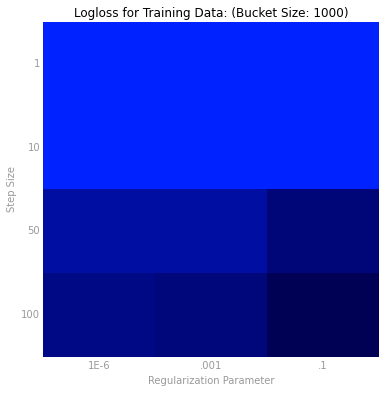

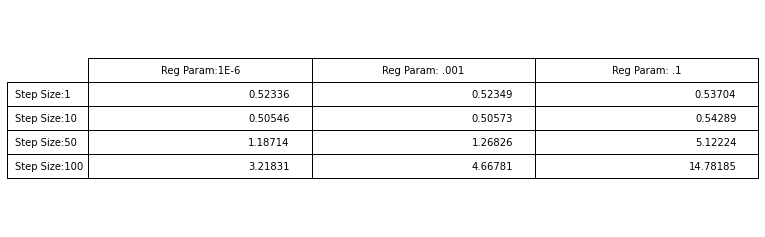

In [72]:
createTable(1000,5,"Logloss for Training Data:")

### B. AUC for Training Data - 1000 buckets

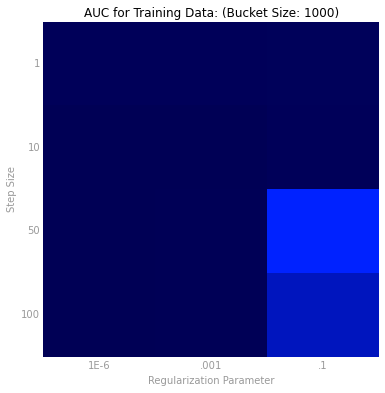

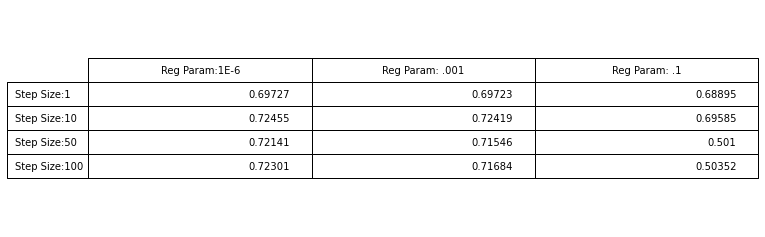

In [80]:
createTable(1000,6,"AUC for Training Data:")

### C. Logloss for Validation Data - 1000 buckets

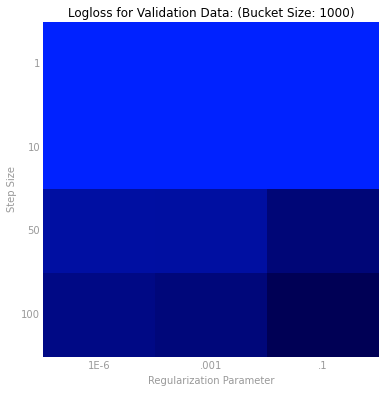

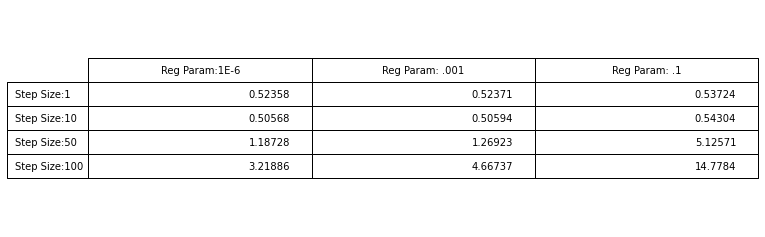

In [81]:
createTable(1000,7,"Logloss for Validation Data:")

### D. AUC for Validation Data - 1000 buckets

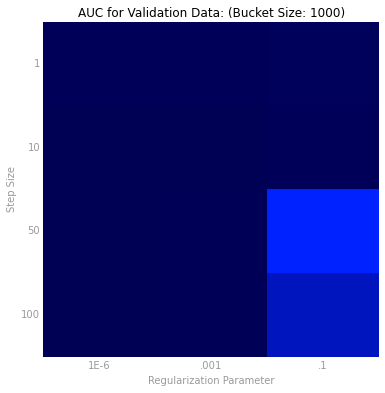

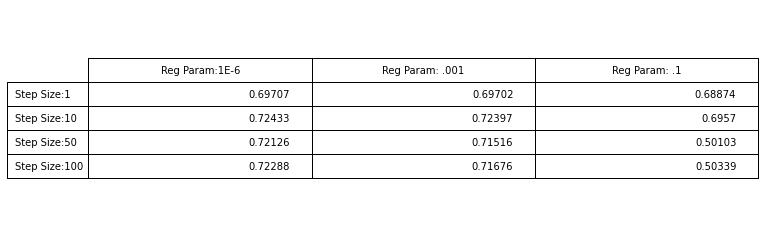

In [82]:
createTable(1000,8,"AUC for Validation Data:")

### E. Logloss for Test Data - 1000 buckets

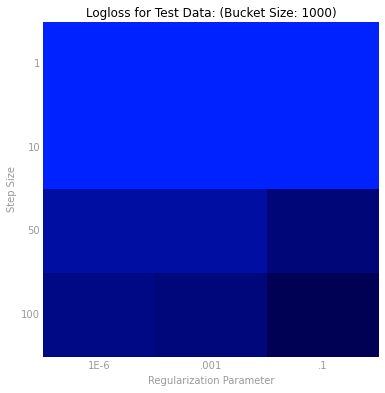

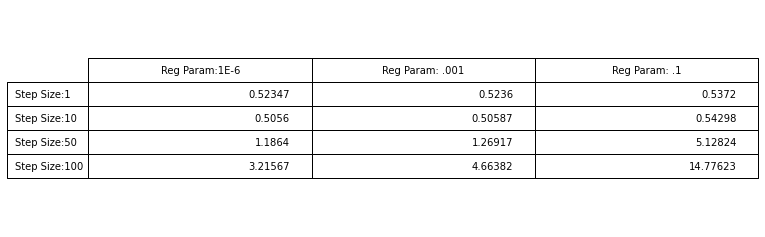

In [83]:
createTable(1000,9,"Logloss for Test Data:")

### F. AUC for Test Data - 1000 buckets

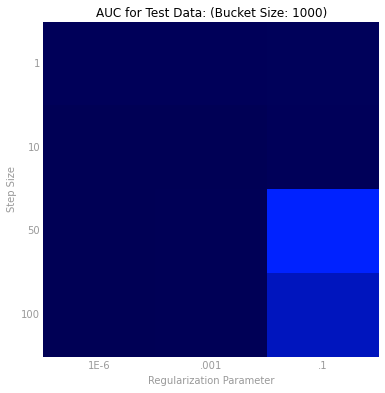

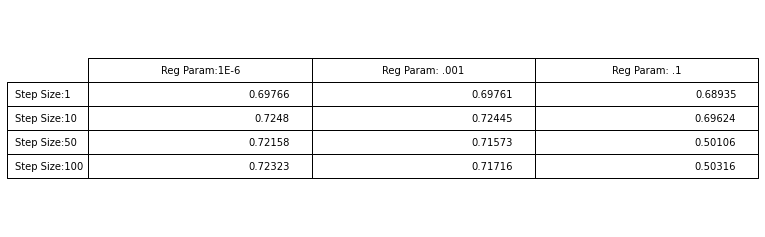

In [84]:
createTable(1000,10,"AUC for Test Data:")

### G. Logloss for Training Data - 10000 buckets

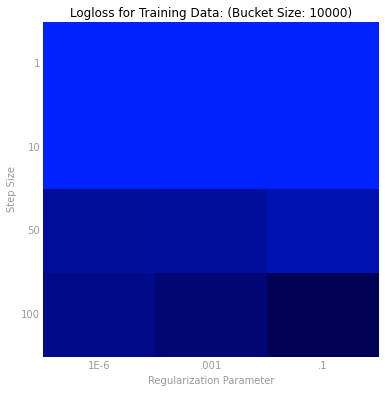

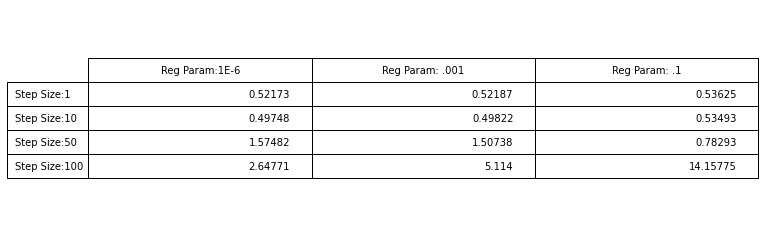

In [85]:
createTable(10000,5,"Logloss for Training Data:")

### H. AUC for Training Data - 10000 buckets

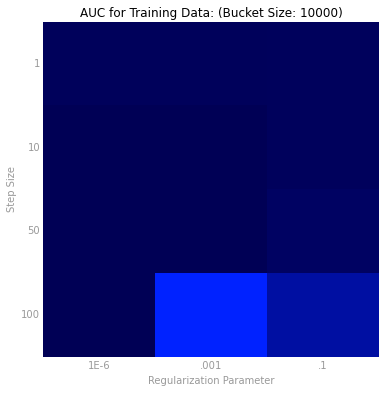

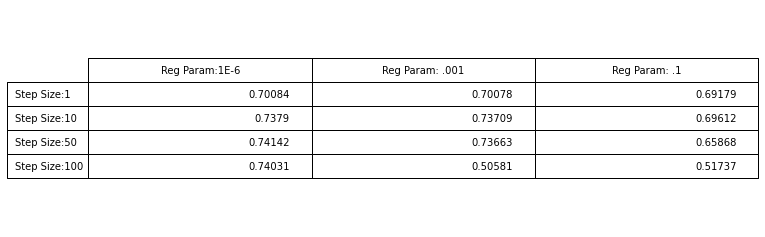

In [86]:
createTable(10000,6,"AUC for Training Data:")

### I. Logloss for Validation Data - 10000 buckets

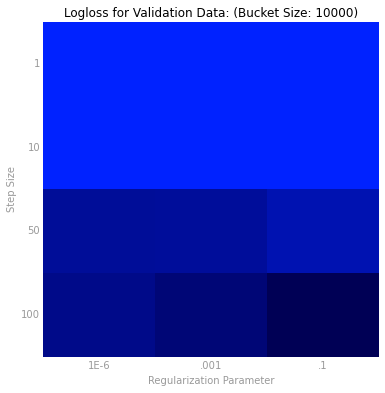

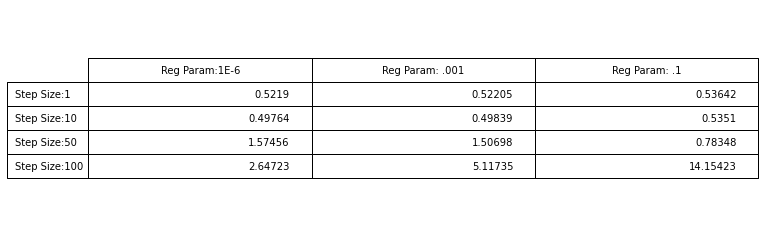

In [87]:
createTable(10000,7,"Logloss for Validation Data:")

### J. AUC for Validation Data - 10000 buckets

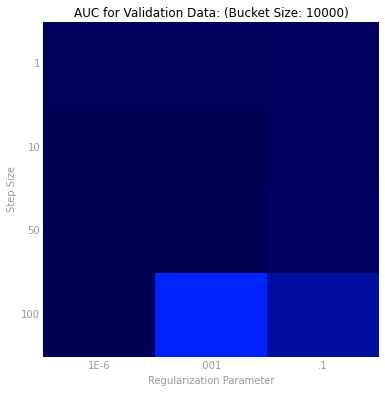

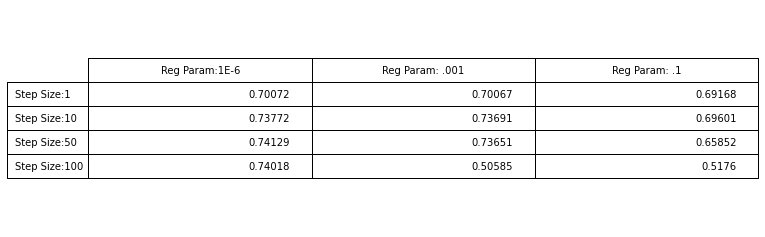

In [88]:
createTable(10000,8,"AUC for Validation Data:")

### K. Logloss for Test Data - 10000 buckets

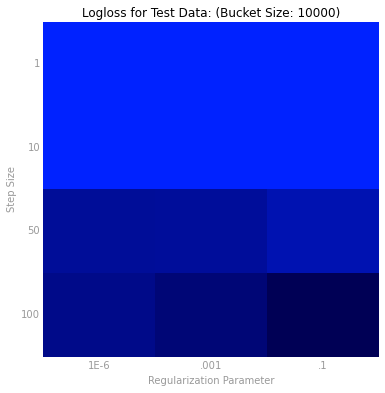

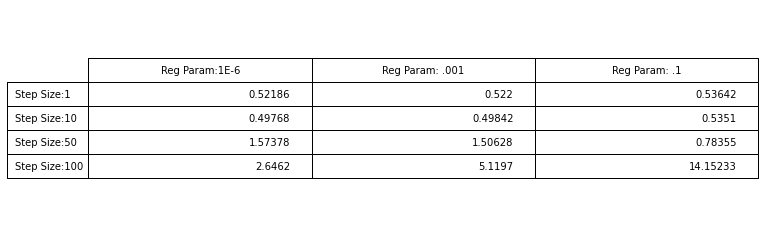

In [89]:
createTable(10000,9,"Logloss for Test Data:")

### L. AUC for Test Data - 10000 buckets

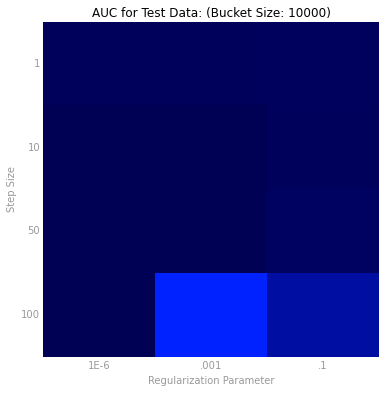

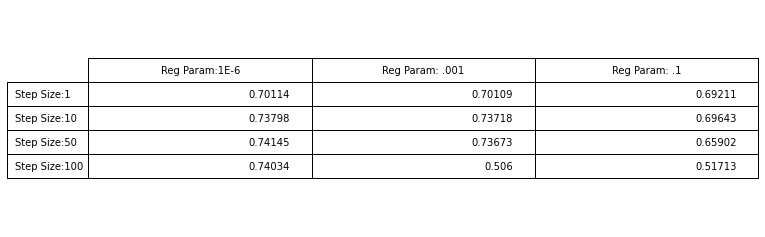

In [90]:
createTable(10000,10,"AUC for Test Data:")

### M. Logloss for Training Data - 50000 buckets

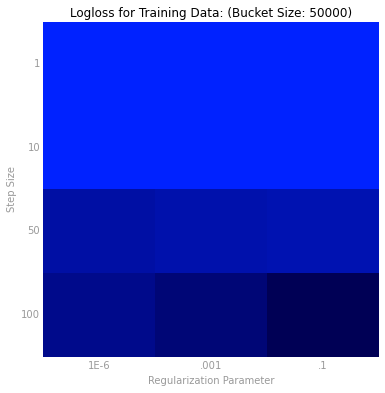

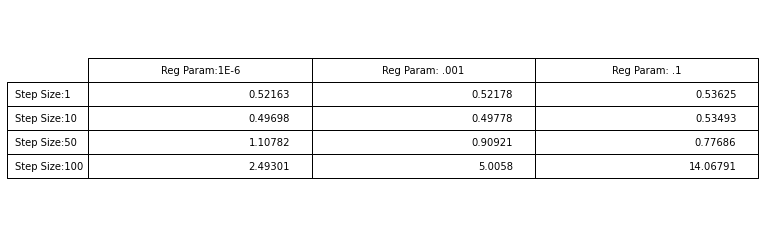

In [91]:
createTable(50000,5,"Logloss for Training Data:")

### N. AUC for Training Data - 50000 buckets

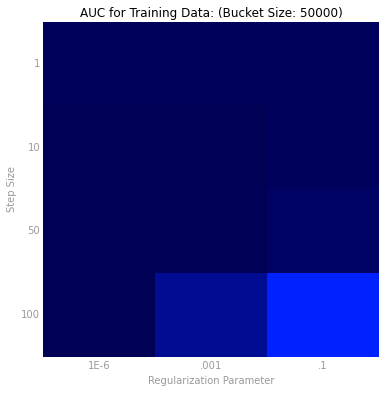

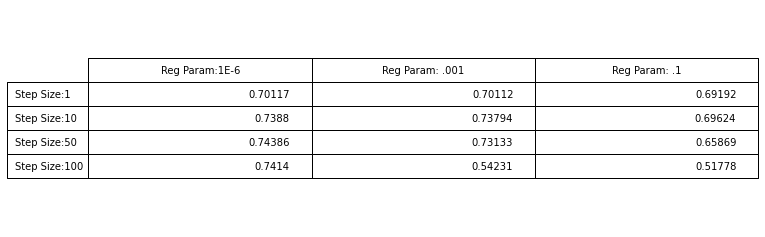

In [92]:
createTable(50000,6,"AUC for Training Data:")

### O. Logloss for Validation Data - 50000 buckets

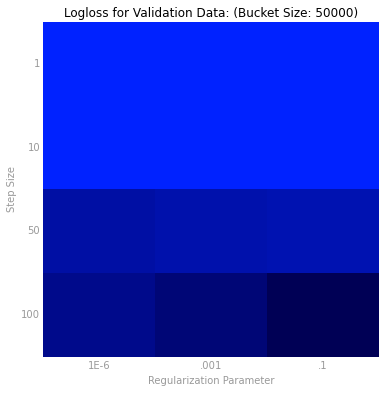

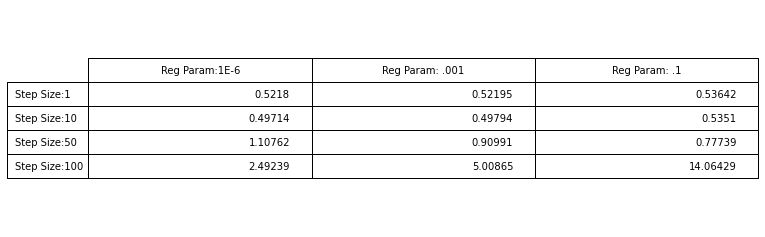

In [93]:
createTable(50000,7,"Logloss for Validation Data:")

### P. AUC for Validation Data - 50000 buckets

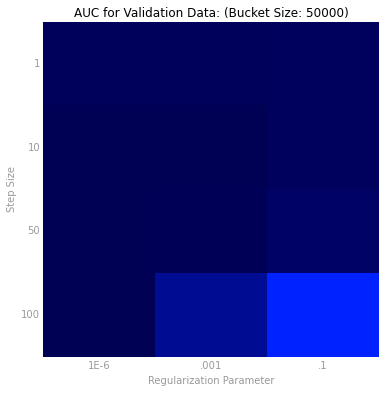

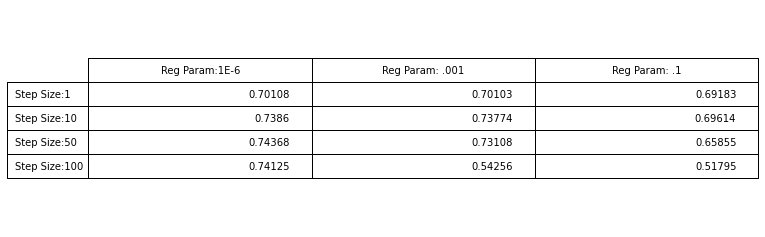

In [94]:
createTable(50000,8,"AUC for Validation Data:")

### Q. Logloss for Test Data - 50000 buckets

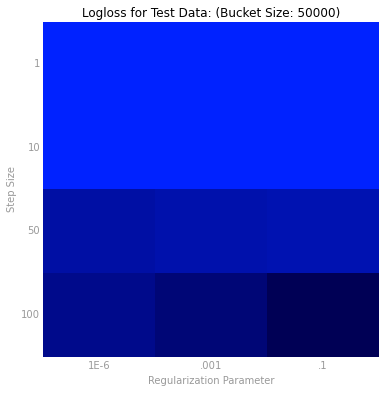

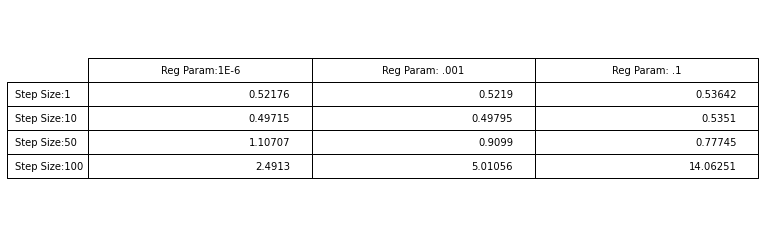

In [95]:
createTable(50000,9,"Logloss for Test Data:")

### R. AUC for Test Data - 50000 buckets

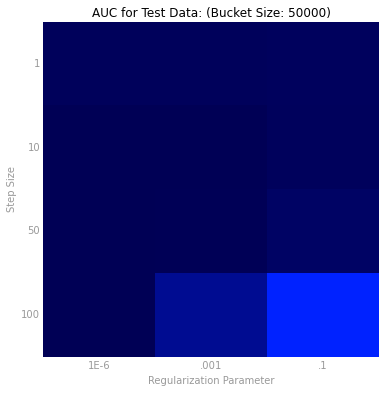

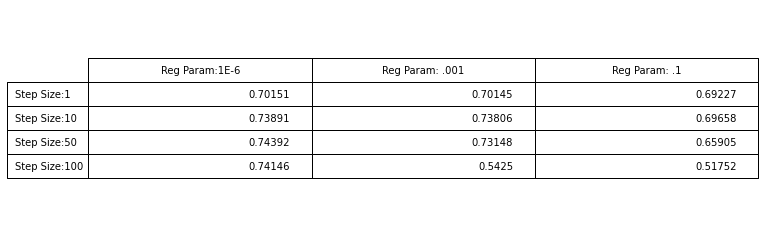

In [96]:
createTable(50000,10,"AUC for Test Data:")

### S. Logloss for Training Data - 100000 buckets

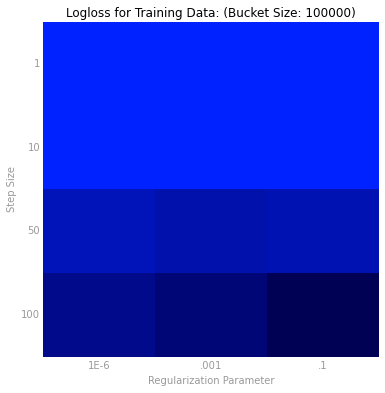

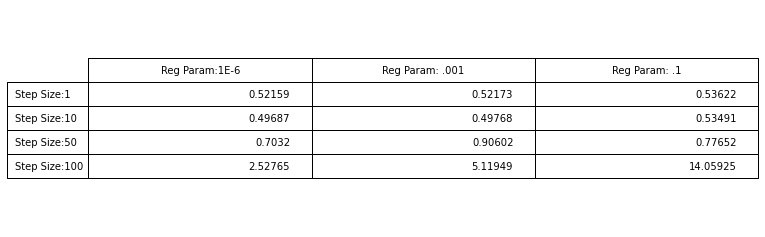

In [97]:
createTable(100000,5,"Logloss for Training Data:")

### T. AUC for Training Data - 100000 buckets

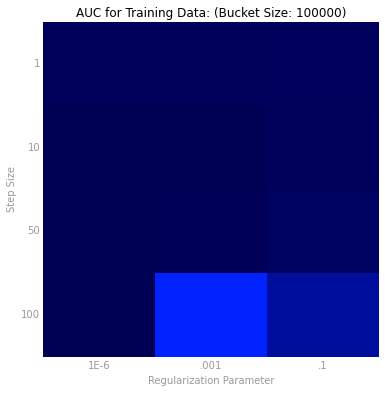

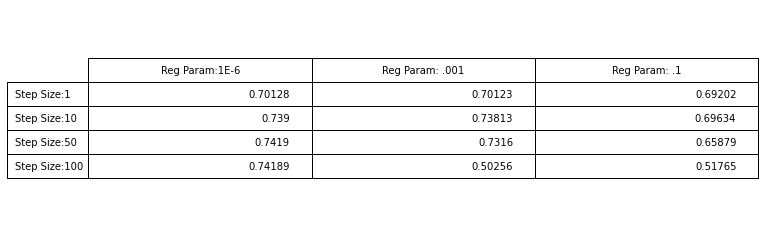

In [98]:
createTable(100000,6,"AUC for Training Data:")

### U. Logloss for Validation Data - 100000 buckets

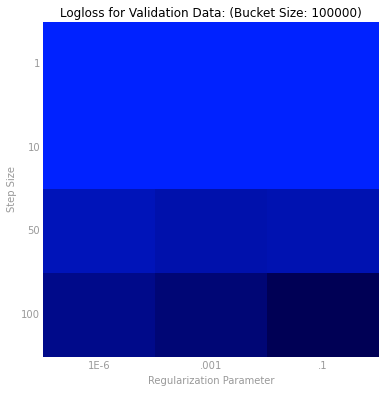

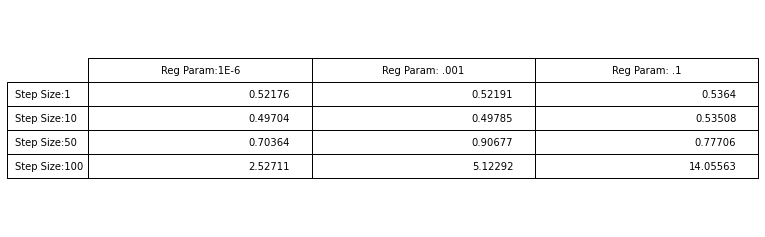

In [99]:
createTable(100000,7,"Logloss for Validation Data:")

### V. AUC for Validation Data - 100000 buckets

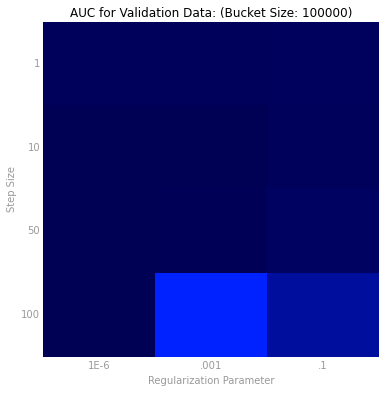

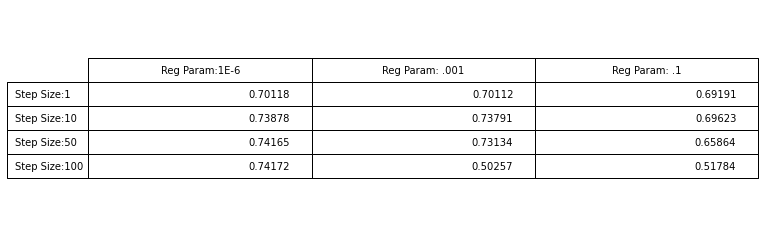

In [100]:
createTable(100000,8,"AUC for Validation Data:")

### W. Logloss for Test Data - 100000 buckets

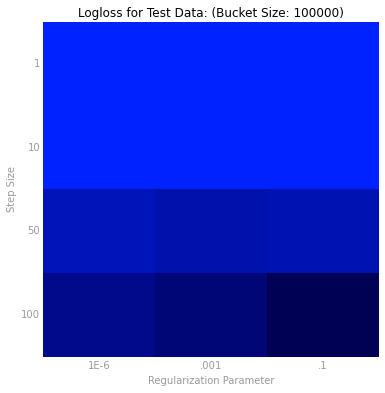

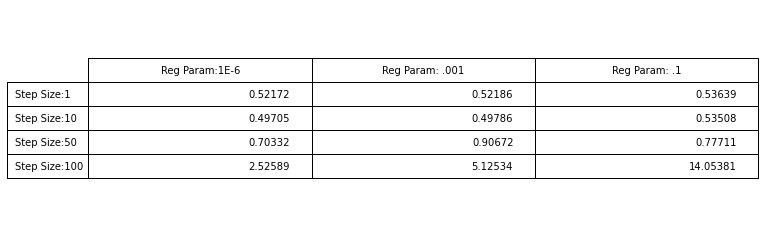

In [101]:
createTable(100000,9,"Logloss for Test Data:")

### X. AUC for Test Data - 100000 buckets

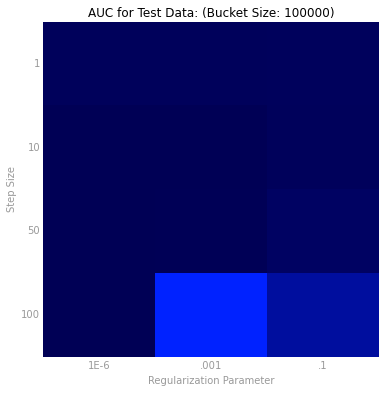

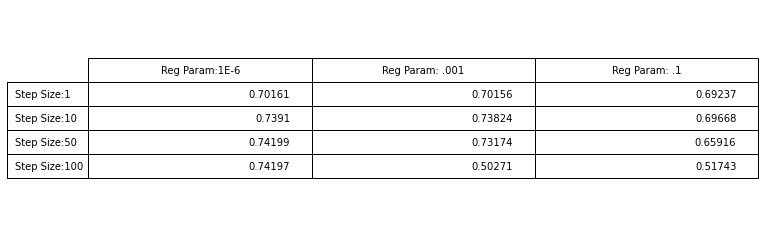

In [79]:
createTable(100000,10,"AUC for Test Data:")